In [76]:
import pandas as pd

import io
import os
import sys
print(sys.path)

## You will change this to whatever the locaiton of the micronetworks package is in your computer
sys.path.append(r'/home/pedrotorres/Desktop/Projects/micronetworks')
print(sys.path)
import micronetworks
from micronetworks.networkstats import *


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

['/home/pedrotorres/Desktop/Projects/micronetworks', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python38.zip', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8/lib-dynload', '', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages', '/home/pedrotorres/Desktop/Projects/micronetworks']
['/home/pedrotorres/Desktop/Projects/micronetworks', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python38.zip', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8/lib-dynload', '', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages', '/home/pedrotorres/Desktop/Projects/micronetworks', '/home/pedrotorres/Desktop/Projects/micronetworks']


### Will be working with data that is on my computer, but information here should be enough to get anyone started with their own data. 

In [105]:
dir_met='/home/pedrotorres/Desktop/Projects/metabolomics_10272022/'
xls = pd.ExcelFile(dir_met+'PR042-22_Persephone_Feces_Microbiome_CDT_102122.xlsx')
metabol_df = pd.read_excel(xls, 'PR042-22_all_data_vertical')

# I do not like the spacing and charcters in the columns so will change that for easier analysis later
metabol_df = metabol_df.rename(columns={'Sample Name':'sample_name','Component Name':'Component_Name',
                           'conc (ug/g wet weight)':'wet_weight_ug/g','%dry weight ':'percent_dry_weight',
                          'conc (ug/g dry weight)':'dry_weight_ug/g'})

# The mapping file for this is the same as what is on the Plate_1_Metadata.xlsx
# Convwersation with Bryce:  Sample_Name 3005 or 3008 in the metabolomics file (Pr04_22..) it is  
# PBT-03005 and PBT-03008 in our Plate_1_metadata.xlsx
# This means we are simply adding a PBT-0 to the front of all sample_names. I checked afew manually and it seems to be the case
# I will double check once i merge with the metadata and make sure we are not missing anything. 
metabol_df['sample_name'] = 'PBT-0'+metabol_df['sample_name'].astype(str)

# also realized that the only sample that does not have a 0 infront of thir name (based on the metabolomics) is sample PBT-3040
# i will manually change this

metabol_df = metabol_df.set_index('sample_name').rename(index={'PBT-3181':'PBT-03181'}).reset_index()
# metabol_df = metabol_df.set_index('sample_name').reset_index()

metabol_df.head(1)

sample_name    Component_Name wet_weight_ug/g  percent_dry_weight  \
0   PBT-03005  2-methylbutyrate              nq            0.066357   

  dry_weight_ug/g  
0              nq

In [106]:
# Let's check to make sure my assumtion above makes sense. 
## There are 50 samples that we got metabolomics from

sample_name_metabolomics = metabol_df['sample_name']
sample_name_metabolomics = pd.DataFrame(sample_name_metabolomics.drop_duplicates())
sample_name_metabolomics.shape

metadata_file = pd.read_csv('/home/pedrotorres/Desktop/Projects/hmo_clusters/Plate_1_Metadata.xlsx.csv')
metadata_file

metabolomics_metadata = pd.merge(sample_name_metabolomics,metadata_file, left_on='sample_name', right_on='BabyBio PBT', how = 'left')
metabolomics_metadata.shape

(50, 12)

In [107]:
# douple check row names are same 
print(sample_name_metabolomics.shape)
print(metabolomics_metadata.shape)

# perfect it matched after we manually changed that naem above. 

(50, 1)
(50, 12)


In [108]:
metabol_df.replace({'nq': 0.0}, inplace=True)
metabol_df_pivot = metabol_df.pivot(index='sample_name', values = 'dry_weight_ug/g', columns = 'Component_Name')
metabol_df_pivot_clr = mr_clr(metabol_df_pivot)
metabol_df_pivot_clr.head(1)

Component_Name  2-methylbutyrate  3-hydroxybenzoate  3-hydroxyhippurate  \
sample_name                                                               
PBT-03005              -0.633454          -0.633454           -3.107344   

Component_Name  3-hydroxyphenylpropionate  3-methylindole  \
sample_name                                                 
PBT-03005                       -0.633454       -3.799605   

Component_Name  4-Ethylphenylsulfate  4-ethylphenol  4-hydroxyphenylacetate  \
sample_name                                                                   
PBT-03005                  -0.633454      -0.633454               -0.633454   

Component_Name  4-hydroxyphenylacrylate  4-hydroxyphenyllactate  ...  \
sample_name                                                      ...   
PBT-03005                     -2.866419                2.371922  ...   

Component_Name  propionate  putrescine  serotonin  trimethylamine  (TMA)  \
sample_name                                                                
PBT-03005         3.233888    3.241656  -0.633454               2.157329   

Component_Name  tryptamine  tryptophan  tyramine  tyrosine  ursodeoxycholate  \
sample_name                                                                    
PBT-03005        -5.790503    1.475842  3.047851  2.285168         -1.836726   

Component_Name  valerate  
sample_name               
PBT-03005      -0.633454  

[1 rows x 79 columns]

## Add species

In [109]:
# # You may do as you would like. I jsut tried to clean up my data a bit and for this I jsut focused on Bifidobacterium taxa
species = pd.read_csv('~/Desktop/Projects/hmo_clusters/full_species_abun_pivot.txt', sep='\t')
##Remove low prevelance species . meaning i do not want to include species that are only present 2 times. 
prev = pd.DataFrame(prevelance(species.set_index('sample_id')))
prevlist = list(prev[prev[0]<=8].reset_index()['index'])
species = species.drop(prevlist, axis=1)
species_clr = mr_clr(species.set_index('sample_id'))



In [110]:
species_metabolites = pd.merge(species_clr.reset_index(),metabol_df_pivot_clr.reset_index(), left_on='sample_id', right_on='sample_name')
species_metabolites = species_metabolites.set_index('sample_id')
species_metabolites = species_metabolites.drop(columns='sample_name')

In [112]:
species_metabolites.shape

(49, 613)

## Add immune

In [ ]:
# Ltes quickly try jus tusing species and immune and HMO since it gives us more smaples and we are more interested in the immune


In [113]:
immune = pd.read_csv('/home/pedrotorres/Desktop/Projects/eve_immune_110722/eve_replaced_oors.tsv', sep='\t')
immune = immune.drop(columns=['my_baby_biome','eve_sample_name','Conc (ug/mL)'])
immune = immune.fillna(0)
immune_clr = mr_clr(immune.set_index('PBT'))
immune_clr.head(1)

sCD40L       EGF  Eotaxin     FGF-2    FLT-3L  Fractalkine  \
PBT                                                                       
PBT-03005  1.955234 -2.596591  0.95504  1.856699 -0.974249     2.547197   

              G-CSF    GM-CSF      GROα    IFN-α2  ...       LIF    MCP-2  \
PBT                                                ...                      
PBT-03005  0.128627 -2.797261 -0.177667  0.274844  ...  0.647928  0.98981   

              MCP-4    MIP-1δ       SCF  SDF-1α+β      TARC       TPO  \
PBT                                                                     
PBT-03005  0.080688 -0.425683 -2.386519  4.079052 -2.195464  0.174373   

              TRAIL      TSLP  
PBT                            
PBT-03005 -0.543466 -1.439138  

[1 rows x 71 columns]

In [46]:
species_immune = pd.merge(species_clr.reset_index(), immune_clr.reset_index(), left_on='sample_id', right_on='PBT').set_index('sample_id').drop(columns=['PBT'])
species_immune

43-108 sp001915545  Acetatifactor sp900066565  \
sample_id                                                  
PBT-03005           -0.669720                  -0.669720   
PBT-03008            4.757436                  -0.905690   
PBT-03015            5.410767                  -0.905880   
PBT-03016           -0.589316                  -0.589316   
PBT-03017            5.586434                  -1.589282   
PBT-03021            6.617263                   2.112941   
PBT-03024            4.140804                  -2.106536   
PBT-03026            4.581710                  -1.433135   
PBT-03029           -1.127838                  -1.127838   
PBT-03051           -0.348137                  -0.348137   
PBT-03055            4.811853                  -1.263248   
PBT-03056            5.687373                  -1.497955   
PBT-03060           -0.914864                  -0.914864   
PBT-03061           -1.011946                  -1.011946   
PBT-03064           -1.163825                  -1.163825   
PBT-03065            2.615267                  -0.765523   
PBT-03067           -0.734826                  -0.734826   
PBT-03070           -0.580422                  -0.580422   
PBT-03074           -1.226472                  -1.226472   
PBT-03075           -1.456591                  -1.456591   
PBT-03076            3.613793                  -1.082622   
PBT-03078           -1.040129                  -1.040129   
PBT-03084            2.695117                  -1.719560   
PBT-03085            3.024479                  -1.300742   
PBT-03088           -0.946485                  -0.946485   
PBT-03089            2.939989                  -0.986734   
PBT-03092            4.077447                  -1.999405   
PBT-03098            4.675168                  -1.263832   
PBT-03100           -1.362185                   2.457335   
PBT-03103            2.833998                   3.562175   
PBT-03111           -0.754118                  -0.754118   
PBT-03112           -0.770479                  -0.770479   
PBT-03116           -1.243118                  -1.243118   
PBT-03130           -1.501019                  -1.501019   
PBT-03143           -0.691674                  -0.691674   
PBT-03145           -1.539514                  -1.539514   
PBT-03147            2.244203                  -1.394161   
PBT-03150           -0.744018                  -0.744018   
PBT-03151            4.357335                  -1.580744   
PBT-03153           -1.277076                  -1.277076   
PBT-03159           -1.043193                   4.087672   
PBT-03174            6.872199                  -1.192687   
PBT-03204           -1.373867                   2.851891   
PBT-03217           -0.454789                  -0.454789   

           Acetatifactor sp900766575  Acinetobacter idrijaensis  \
sample_id                                                         
PBT-03005                  -0.669720                  -0.669720   
PBT-03008                  -0.905690                  -0.905690   
PBT-03015                  -0.905880                  -0.905880   
PBT-03016                  -0.589316                  -0.589316   
PBT-03017                   3.136660                  -1.589282   
PBT-03021                  -1.677554                  -1.677554   
PBT-03024                  -2.106536                  -2.106536   
PBT-03026                  -1.433135                  -1.433135   
PBT-03029                  -1.127838                  -1.127838   
PBT-03051                  -0.348137                  -0.348137   
PBT-03055                  -1.263248                   3.272837   
PBT-03056                  -1.497955                  -1.497955   
PBT-03060                  -0.914864                  -0.914864   
PBT-03061                   2.903535                  -1.011946   
PBT-03064                  -1.163825                  -1.163825   
PBT-03065                   5.221944                   3.928996   
PBT-03067                  -0.734826        

In [114]:
species_metabolites_immune = pd.merge(species_metabolites.reset_index(), immune_clr.reset_index(), 
                                      left_on='sample_id', right_on='PBT')
species_metabolites_immune = species_metabolites_immune.set_index('sample_id').drop(columns=['PBT'])
species_metabolites_immune.head(1)

43-108 sp001915545  Acetatifactor sp900066565  \
sample_id                                                  
PBT-03005            -0.66972                   -0.66972   

           Acetatifactor sp900766575  Acinetobacter idrijaensis  \
sample_id                                                         
PBT-03005                   -0.66972                   -0.66972   

           Alistipes finegoldii  Alistipes onderdonkii  Alistipes shahii  \
sample_id                                                                  
PBT-03005              -0.66972               -0.66972          -0.66972   

           Alistipes sp900552955  Alistipes sp902363575  \
sample_id                                                 
PBT-03005               -0.66972               -0.66972   

           Alkalihalobacillus_A sp007293315  ...       LIF    MCP-2     MCP-4  \
sample_id                                    ...                                
PBT-03005                          4.204025  ...  0.647928  0.98981  0.080688   

             MIP-1δ       SCF  SDF-1α+β      TARC       TPO     TRAIL  \
sample_id                                                               
PBT-03005 -0.425683 -2.386519  4.079052 -2.195464  0.174373 -0.543466   

               TSLP  
sample_id            
PBT-03005 -1.439138  

[1 rows x 684 columns]

In [118]:
 missing = pd.merge(species_metabolites.reset_index(), immune_clr.reset_index(), 
                                      left_on='sample_id', right_on='PBT',how='right')[['sample_id','PBT','43-108 sp001915545']]
    
missing[missing['43-108 sp001915545'].isna()]

sample_id        PBT  43-108 sp001915545
44       NaN  PBT-00177                 NaN
45       NaN  PBT-00210                 NaN
46       NaN  PBT-00211                 NaN
47       NaN  PBT-00247                 NaN
48       NaN  PBT-00254                 NaN
49       NaN  PBT-00256                 NaN
50       NaN  PBT-00260                 NaN
51       NaN  PBT-00261                 NaN
52       NaN  PBT-00263                 NaN
53       NaN  PBT-00267                 NaN
54       NaN  PBT-00268                 NaN
55       NaN  PBT-00270                 NaN
56       NaN  PBT-00279                 NaN
57       NaN  PBT-00284                 NaN
58       NaN  PBT-00325                 NaN
59       NaN  PBT-00326                 NaN
60       NaN  PBT-00334                 NaN
61       NaN  PBT-01039                 NaN
62       NaN  PBT-01040                 NaN
63       NaN  PBT-01065                 NaN
64       NaN  PBT-01066                 NaN
65       NaN  PBT-01097                 NaN
66       NaN  PBT-01113                 NaN
67       NaN  PBT-01123                 NaN
68       NaN  PBT-01125                 NaN
69       NaN  PBT-01128                 NaN
70       NaN  PBT-00166                 NaN
71       NaN  PBT-00195                 NaN

In [115]:
species_metabolites_immune.shape

(44, 684)

# add HMO 

In [17]:
hmo = pd.read_csv('/home/pedrotorres/Desktop/Projects/baby_biome_p1_p4_12132022/hmo_clr_plate1_plate4.csv')
hmo# sample_id
species_metabolites_immune_hmo = pd.merge(species_metabolites_immune.reset_index(), hmo, on = 'sample_id', how='left').fillna(0).set_index('sample_id')
species_metabolites_immune_hmo

43-108 sp001915545  Acetatifactor sp900066565  \
sample_id                                                  
PBT-03005           -0.669720                  -0.669720   
PBT-03008            4.757436                  -0.905690   
PBT-03015            5.410767                  -0.905880   
PBT-03016           -0.589316                  -0.589316   
PBT-03017            5.586434                  -1.589282   
PBT-03021            6.617263                   2.112941   
PBT-03024            4.140804                  -2.106536   
PBT-03026            4.581710                  -1.433135   
PBT-03029           -1.127838                  -1.127838   
PBT-03051           -0.348137                  -0.348137   
PBT-03055            4.811853                  -1.263248   
PBT-03056            5.687373                  -1.497955   
PBT-03060           -0.914864                  -0.914864   
PBT-03061           -1.011946                  -1.011946   
PBT-03064           -1.163825                  -1.163825   
PBT-03065            2.615267                  -0.765523   
PBT-03067           -0.734826                  -0.734826   
PBT-03070           -0.580422                  -0.580422   
PBT-03074           -1.226472                  -1.226472   
PBT-03075           -1.456591                  -1.456591   
PBT-03076            3.613793                  -1.082622   
PBT-03078           -1.040129                  -1.040129   
PBT-03084            2.695117                  -1.719560   
PBT-03085            3.024479                  -1.300742   
PBT-03088           -0.946485                  -0.946485   
PBT-03089            2.939989                  -0.986734   
PBT-03092            4.077447                  -1.999405   
PBT-03098            4.675168                  -1.263832   
PBT-03100           -1.362185                   2.457335   
PBT-03103            2.833998                   3.562175   
PBT-03111           -0.754118                  -0.754118   
PBT-03112           -0.770479                  -0.770479   
PBT-03116           -1.243118                  -1.243118   
PBT-03130           -1.501019                  -1.501019   
PBT-03143           -0.691674                  -0.691674   
PBT-03145           -1.539514                  -1.539514   
PBT-03147            2.244203                  -1.394161   
PBT-03150           -0.744018                  -0.744018   
PBT-03151            4.357335                  -1.580744   
PBT-03153           -1.277076                  -1.277076   
PBT-03159           -1.043193                   4.087672   
PBT-03174            6.872199                  -1.192687   
PBT-03204           -1.373867                   2.851891   
PBT-03217           -0.454789                  -0.454789   

           Acetatifactor sp900766575  Acinetobacter idrijaensis  \
sample_id                                                         
PBT-03005                  -0.669720                  -0.669720   
PBT-03008                  -0.905690                  -0.905690   
PBT-03015                  -0.905880                  -0.905880   
PBT-03016                  -0.589316                  -0.589316   
PBT-03017                   3.136660                  -1.589282   
PBT-03021                  -1.677554                  -1.677554   
PBT-03024                  -2.106536                  -2.106536   
PBT-03026                  -1.433135                  -1.433135   
PBT-03029                  -1.127838                  -1.127838   
PBT-03051                  -0.348137                  -0.348137   
PBT-03055                  -1.263248                   3.272837   
PBT-03056                  -1.497955                  -1.497955   
PBT-03060                  -0.914864                  -0.914864   
PBT-03061                   2.903535                  -1.011946   
PBT-03064                  -1.163825                  -1.163825   
PBT-03065                   5.221944                   3.928996   
PBT-03067                  -0.734826        

In [47]:
### Focus on only immun eand hmo and species
species_immune_hmo = pd.merge(species_immune.reset_index(), hmo, on = 'sample_id', how='left').fillna(0).set_index('sample_id')
species_immune_hmo

43-108 sp001915545  Acetatifactor sp900066565  \
sample_id                                                  
PBT-03005           -0.669720                  -0.669720   
PBT-03008            4.757436                  -0.905690   
PBT-03015            5.410767                  -0.905880   
PBT-03016           -0.589316                  -0.589316   
PBT-03017            5.586434                  -1.589282   
PBT-03021            6.617263                   2.112941   
PBT-03024            4.140804                  -2.106536   
PBT-03026            4.581710                  -1.433135   
PBT-03029           -1.127838                  -1.127838   
PBT-03051           -0.348137                  -0.348137   
PBT-03055            4.811853                  -1.263248   
PBT-03056            5.687373                  -1.497955   
PBT-03060           -0.914864                  -0.914864   
PBT-03061           -1.011946                  -1.011946   
PBT-03064           -1.163825                  -1.163825   
PBT-03065            2.615267                  -0.765523   
PBT-03067           -0.734826                  -0.734826   
PBT-03070           -0.580422                  -0.580422   
PBT-03074           -1.226472                  -1.226472   
PBT-03075           -1.456591                  -1.456591   
PBT-03076            3.613793                  -1.082622   
PBT-03078           -1.040129                  -1.040129   
PBT-03084            2.695117                  -1.719560   
PBT-03085            3.024479                  -1.300742   
PBT-03088           -0.946485                  -0.946485   
PBT-03089            2.939989                  -0.986734   
PBT-03092            4.077447                  -1.999405   
PBT-03098            4.675168                  -1.263832   
PBT-03100           -1.362185                   2.457335   
PBT-03103            2.833998                   3.562175   
PBT-03111           -0.754118                  -0.754118   
PBT-03112           -0.770479                  -0.770479   
PBT-03116           -1.243118                  -1.243118   
PBT-03130           -1.501019                  -1.501019   
PBT-03143           -0.691674                  -0.691674   
PBT-03145           -1.539514                  -1.539514   
PBT-03147            2.244203                  -1.394161   
PBT-03150           -0.744018                  -0.744018   
PBT-03151            4.357335                  -1.580744   
PBT-03153           -1.277076                  -1.277076   
PBT-03159           -1.043193                   4.087672   
PBT-03174            6.872199                  -1.192687   
PBT-03204           -1.373867                   2.851891   
PBT-03217           -0.454789                  -0.454789   

           Acetatifactor sp900766575  Acinetobacter idrijaensis  \
sample_id                                                         
PBT-03005                  -0.669720                  -0.669720   
PBT-03008                  -0.905690                  -0.905690   
PBT-03015                  -0.905880                  -0.905880   
PBT-03016                  -0.589316                  -0.589316   
PBT-03017                   3.136660                  -1.589282   
PBT-03021                  -1.677554                  -1.677554   
PBT-03024                  -2.106536                  -2.106536   
PBT-03026                  -1.433135                  -1.433135   
PBT-03029                  -1.127838                  -1.127838   
PBT-03051                  -0.348137                  -0.348137   
PBT-03055                  -1.263248                   3.272837   
PBT-03056                  -1.497955                  -1.497955   
PBT-03060                  -0.914864                  -0.914864   
PBT-03061                   2.903535                  -1.011946   
PBT-03064                  -1.163825                  -1.163825   
PBT-03065                   5.221944                   3.928996   
PBT-03067                  -0.734826        

In [70]:
# hno immun eonlu
hmo_immune = pd.merge(hmo, immune_clr.reset_index(), left_on='sample_id', right_on='PBT').set_index('sample_id')#.drop(columns=['PBT'])
hmo_immune

H1        H2        H3        H4        H5    Urease  \
sample_id                                                               
PBT-03008 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03015 -0.905479 -0.905479 -0.905479  1.472700  2.149217 -0.905479   
PBT-03016  0.282601 -1.370002 -1.370002  0.278824  1.215158  0.963420   
PBT-03017 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03021 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03024 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03026 -1.133785  0.404954 -1.133785  1.301673  1.694726 -1.133785   
PBT-03029  0.975646 -0.563104 -1.058187  0.414963  0.059198  0.171485   
PBT-03051 -0.905685 -0.905685 -0.905685  1.475006  2.147733 -0.905685   
PBT-03055 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03056 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03060 -0.367590 -0.042348 -0.319783  0.696918  1.519569 -1.486766   
PBT-03061 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03064  0.990949 -1.054229 -1.054229  0.720305  1.929008 -1.531804   
PBT-03065 -1.104215 -0.434325 -0.171960  0.789451  2.025264 -1.104215   
PBT-03067 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03070 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03074  1.011332 -1.128735 -1.189359  0.950707  1.545414 -1.189359   
PBT-03075  0.603941 -1.163919 -1.163919 -1.163919  1.430046  1.457771   
PBT-03076 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03078 -0.918628 -0.918628 -0.918628  1.653958  2.020552 -0.918628   
PBT-03084 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03085 -0.893059 -0.893059 -0.893059  1.347127  2.225109 -0.893059   
PBT-03088 -0.856088 -0.856088 -0.856088  1.050945  2.373408 -0.856088   
PBT-03089 -0.890805 -0.890805 -0.890805  1.326499  2.236721 -0.890805   
PBT-03092  0.145905 -4.194852  0.145905  0.145905  3.611233  0.145905   
PBT-03098 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03100 -0.897454 -0.897454 -0.897454  1.388968  2.200849 -0.897454   
PBT-03103 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03111 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03112  1.328655 -1.362174 -1.425915  0.679959  0.272318  0.507158   
PBT-03116 -1.091428  0.231524 -1.091428  1.143471  1.899290 -1.091428   
PBT-03130 -0.881843 -0.881843 -0.881843  1.248845  2.278528 -0.881843   
PBT-03145 -0.895280 -0.895280 -0.895280  1.367986  2.213135 -0.895280   
PBT-03147 -0.902985 -0.902985 -0.902985  1.445428  2.166512 -0.902985   
PBT-03150 -0.572331 -0.572331 -0.572331 -0.572331  2.861656 -0.572331   
PBT-03151 -0.742606 -0.742606 -0.742606 -0.742606  2.625866  0.344559   
PBT-03153 -0.913651 -0.913651 -0.913651  1.574430  2.080172 -0.913651   
PBT-03174 -0.918602 -0.918602 -0.918602  1.653480  2.020927 -0.918602   
PBT-03204  1.560131 -3.499823  0.006734  0.923025  1.747639 -0.737706   
PBT-03217 -1.121463  0.376536 -1.121463  1.200925  1.786928 -1.121463   

                 PBT    sCD40L       EGF   Eotaxin  ...       LIF     MCP-2  \
sample_id                                           ...                       
PBT-03008  PBT-03008  1.591466 -1.102611 -0.360889  ...  0.893720  0.694414   
PBT-03015  PBT-03015 -0.178881 -0.197929 -0.838298  ...  0.584631  0.171945   
PBT-03016  PBT-03016  2.069802 -2.768848  0.442205  ...  1.645916  1.610741   
PBT-03017  PBT-03017  0.026141 -2.619388  0.411435  ...  1.061341  1.054773   
PBT-03021  PBT-03021 -1.880379 -2.121541  0.457298  ...  2.482330 -0.593228   
PBT-03024  PBT-03024 -1.975999  0.853606  0.813662  ... -3.159770  0.961974   
PBT-03026  PBT-03026  0.864137 -3.322167 -0.551203  ...  1.062291  0.900011   
PBT-03029  PBT-03029 -0.413375 -3.058904 -0.377172  ...  0.198193  0.120231   
PBT-03051  PBT-03051  1.015844 -2.024340  0.258572  ... -0.599825 -0.496028   
PBT-0305

In [59]:
## hmo and imune only
pearson_immune_hmo = calculate_corrcoef_pvalues(hmo_immune,pearsonr)

In [48]:
# species immune and hmo ponly
pearson_species_immune_hmo = calculate_corrcoef_pvalues(species_immune_hmo,pearsonr)

In [18]:
# get correlation p value matrix
pearson_species_metabolites_immune_hmo = calculate_corrcoef_pvalues(species_metabolites_immune_hmo,pearsonr)

In [19]:

pearson_coeff_pval_corr = merge_corr_coef_pvalue_corr(species_metabolites_immune_hmo, pearson_species_metabolites_immune_hmo, corr_coef=0, pval=1)


In [49]:
pearson_coeff_pval_corr_species_hmo_immune = merge_corr_coef_pvalue_corr(species_immune_hmo, pearson_species_immune_hmo, corr_coef=0, pval=1)


In [60]:
# hmo and immune only
pearson_coeff_pval_corr_hmo_immune = merge_corr_coef_pvalue_corr(hmo_immune, pearson_immune_hmo, corr_coef=0, pval=1)


In [75]:
pearson_coeff_pval_corr_hmo_immune[pearson_coeff_pval_corr_hmo_immune['var1']=='H4'].sort_values('pvalue_corr').head(50)

var1          var2    pvalue pvalue_corr  corr_coeff
232   H4        Urease  0.000924    0.038081   -0.497924
231   H4            H5   0.00223    0.066195   -0.464274
233   H4        sCD40L  0.007208    0.136586    0.413473
230   H4            H3  0.014508    0.172568   -0.379108
290   H4         IL-21  0.014911    0.173638   -0.377689
289   H4         IL-20  0.055164    0.319621   -0.301785
236   H4         FGF-2  0.069955    0.359103    0.285919
287   H4         I-309  0.082839    0.390113   -0.274136
240   H4        GM-CSF  0.087451    0.394877    0.270267
285   H4     Eotaxin-2  0.102529    0.422535   -0.258626
300   H4          TARC  0.125869     0.45495   -0.242955
291   H4         IL-23  0.145202    0.483957   -0.231553
260   H4        IL-17A  0.145682    0.484943    0.231284
274   H4       PDGF-AA  0.160272    0.505341    0.223419
295   H4         MCP-2  0.162068    0.506729   -0.222487
277   H4          TGFα  0.182737    0.528629    0.212266
279   H4          TNFβ  0.186162    0.531655    0.210654
296   H4         MCP-4  0.200188    0.543366   -0.204261
257   H4      IL-12p70  0.208621    0.552922    0.200568
276   H4        RANTES  0.214705    0.564445   -0.197967
288   H4         IL-16    0.2214    0.572782   -0.195164
303   H4          TSLP  0.239517    0.591814   -0.187859
247   H4          IL-2  0.244653    0.597542    0.185857
246   H4        IL-1RA  0.251687    0.603142    0.183161
237   H4        FLT-3L  0.265653    0.618379   -0.177953
280   H4        VEGF-A  0.275312    0.628854   -0.174456
270   H4           MDC  0.285702    0.638137   -0.170784
292   H4        IL-28A  0.295076     0.64811   -0.167544
262   H4        IL-17F  0.298333    0.649531    0.166434
228   H4            H1  0.301161    0.651712   -0.165476
301   H4           TPO  0.333489    0.674134   -0.154914
252   H4          IL-7  0.332923    0.674134    0.155093
265   H4         IL-27  0.358002    0.695099   -0.147322
251   H4          IL-6  0.365017    0.702594   -0.145208
302   H4         TRAIL  0.374171    0.710926   -0.142486
273   H4        MIP-1β  0.385423    0.718962   -0.139194
264   H4         IL-22  0.386886     0.72012    0.138770
299   H4      SDF-1α+β  0.432243    0.751934   -0.126061
261   H4  IL-17E/IL-25  0.432836    0.751934    0.125900
238   H4   Fractalkine  0.439218    0.755528    0.124174
234   H4           EGF  0.506075    0.794379   -0.106856
248   H4          IL-3  0.518678    0.798588   -0.103727
254   H4          IL-9   0.51911    0.798588    0.103621
294   H4           LIF  0.525214    0.800728   -0.102120
235   H4       Eotaxin  0.546477    0.813322   -0.096956
256   H4      IL-12p40  0.548638    0.814054    0.096437
239   H4         G-CSF  0.586701    0.834022   -0.087441
245   H4         IL-1β  0.599272    0.839784    0.084528
297   H4        MIP-1δ   0.60541    0.841552    0.083116
267   H4         MCP-1  0.618228    0.847804    0.080185

In [57]:

pearson_coeff_pval_corr_species_hmo_immune[pearson_coeff_pval_corr_species_hmo_immune['var1']=='Urease'].sort_values('pvalue_corr').head(50)

var1                             var2    pvalue pvalue_corr  \
372462  Urease           Limivivens sp900543575  0.000206     0.01322   
372120  Urease        Anaerotruncus colihominis   0.00034    0.019698   
372708  Urease                               H4  0.000453    0.024661   
372379  Urease       Enterococcus_C saigonensis  0.000599    0.030555   
372216  Urease            Blautia_A sp900549015  0.000747    0.036163   
372171  Urease            Bifidobacterium breve  0.000885    0.041099   
372368  Urease        Enterocloster sp900538485  0.000898    0.041515   
372463  Urease     Limosilactobacillus pontis_A   0.00156    0.062189   
372421  Urease             HGM11521 sp900751885  0.002493    0.086792   
372405  Urease         Faecalimonas sp900551895  0.002813     0.09445   
372705  Urease                               H1  0.003109    0.101089   
372597  Urease              UBA9414 sp018365895   0.00394    0.118378   
372337  Urease          Collinsella sp905208635  0.003952    0.118575   
372537  Urease            Roseburia sp910577925  0.005343    0.145191   
372207  Urease            Blautia_A sp003471165  0.005371    0.145701   
372449  Urease  Lachnoclostridium_B sp900066765  0.006372    0.162251   
372551  Urease        Schaedlerella sp905203555  0.006473    0.163984   
372195  Urease              Blautia sp000432195  0.006563     0.16534   
372212  Urease            Blautia_A sp900540785  0.006566    0.165373   
372523  Urease         Pisciglobus halotolerans   0.00658    0.165637   
372118  Urease         Anaerostipes sp900756035  0.006764    0.168371   
372376  Urease            Enterococcus_B lactis   0.00764     0.18091   
372598  Urease               UBA945 sp900549675   0.00776    0.182573   
372375  Urease           Enterococcus_B faecium  0.008213    0.189378   
372179  Urease         Bifidobacterium myosotis  0.008249    0.189807   
372435  Urease             Klebsiella aerogenes  0.008488    0.192979   
372407  Urease          Faecalimonas umbilicata  0.009773    0.210166   
372321  Urease          Collinsella sp900555815  0.010031    0.213264   
372122  Urease                 BX12 sp902363595  0.010757    0.222892   
372377  Urease         Enterococcus_B mundtii_B  0.011383    0.230283   
372593  Urease             UBA11774 sp900556645  0.011565    0.232511   
372401  Urease          Faecalimonas phoceensis  0.012063    0.238541   
372314  Urease          Collinsella sp900554465  0.012354    0.241709   
372214  Urease            Blautia_A sp900547615  0.012704    0.245105   
372210  Urease            Blautia_A sp900066205  0.012809    0.246323   
372193  Urease                 Blautia hansenii  0.013122    0.249353   
372383  Urease          Enterococcus_G italicus  0.014022    0.258168   
372349  Urease              Dorea_B phocaeensis  0.014137    0.259208   
372177  Urease           Bifidobacterium longum  0.015379    0.271942   
372378  Urease  Enterococcus_C mediterraneensis  0.016119    0.279009   
372218  Urease            Blautia_A sp905209435   0.01719    0.288804   
372204  Urease                   Blautia_A luti  0.017856    0.294091   
372540  Urease       Ruminococcus_B sp900544395  0.019389     0.30807   
372611  Urease            Veillonella nakazawae  0.019638    0.309827   
372434  Urease             JAGZLR01 sp018364635  0.020272     0.31411   
372481  Urease           Onthomonas sp900758315   0.02036    0.314749   
372324  Urease          Collinsella sp900557505  0.020942    0.318745   
372602  Urease             UMGS1375 sp900066615   0.02325    0.335583   
372359  Urease               Enterobacter kobei  0.024057    0.340902   
372233  Urease              CAG-317 sp000433215  0.026379    0.355519   

        corr_coeff  
372462    0.531410  
372120    0.515684  
372708   -0.506385  
372379    0.497032  
372216    0.489461  
372171   -0.483484  
372368    0.482996  
372463   -0.462813  
372421    0.444671  
372405    0.439838  
372705    0.435780  
372597    0.425962  
372337   -0.4

In [27]:
pearson_coeff_pval_corr[pearson_coeff_pval_corr['var2']=='H4'].sort_values('pvalue_corr').head(50)

var1 var2    pvalue pvalue_corr  \
49605                  Bifidobacterium breve   H4       0.0         0.0   
250793          Limosilactobacillus pontis_A   H4       0.0    0.000001   
55117               Bifidobacterium myosotis   H4  0.000002    0.000386   
57873                Bifidobacterium reuteri   H4  0.000005    0.000839   
51672               Bifidobacterium infantis   H4  0.000134    0.011256   
475408                                Urease   H4  0.000453    0.028813   
399617                      indole-3-lactate   H4   0.00138     0.06503   
60629            Bifidobacterium sp002742445   H4  0.001681    0.074561   
407885                          lithocholate   H4  0.002414    0.095762   
99902                Caulobacter sp003931565   H4  0.003647    0.125195   
190161                Enterococcus_B faecium   H4  0.003895    0.130868   
388593                              arginine   H4  0.005924    0.170659   
24801                 Bacteroides fragilis_A   H4  0.007165    0.190497   
53739                 Bifidobacterium longum   H4   0.00753    0.195974   
374813                4-hydroxyphenyllactate   H4  0.007866     0.20082   
278353              Pauljensenia sp902373435   H4  0.008184    0.205731   
17911         Bacteroides bouchesdurhonensis   H4  0.008415    0.208803   
377569                            Enterodiol   H4  0.008434    0.209106   
163979               Collinsella sp905208635   H4   0.00887    0.214519   
62007            Bifidobacterium sp018555355   H4   0.01076    0.241001   
473340                                    H3   H4  0.011051    0.244225   
127462               Collinsella sp900548495   H4    0.0115    0.249743   
56495             Bifidobacterium pullorum_B   H4  0.014267     0.27864   
287999               Phocaeicola sp900551445   H4  0.016907     0.30415   
423043                                sCD40L   H4  0.016915    0.304227   
282487              Phocaeicola massiliensis   H4  0.017303    0.308206   
462316                                 IL-21   H4  0.017328    0.308321   
403751                       indoxyl sulfate   H4  0.019422    0.326261   
292133              Pisciglobus halotolerans   H4   0.01946    0.326538   
411330                      p-cresol sulfate   H4  0.020916     0.33682   
319693                 Streptococcus equinus   H4  0.021381    0.340547   
26868             Bacteroides intestinalis_A   H4  0.023741    0.357292   
100591               Choladocola sp003480725   H4  0.024801    0.364067   
48916                Bifidobacterium bifidum   H4  0.024987    0.365132   
80610                  Blautia_A sp900549015   H4  0.025382    0.367561   
274219                  Paraprevotella clara   H4  0.028514    0.386256   
361033               Veillonella sp900757715   H4  0.030647    0.398544   
47538           Bifidobacterium adolescentis   H4   0.03491     0.42013   
208075               Faecalimonas phoceensis   H4   0.03587    0.425152   
275597            Paraprevotella sp905215575   H4  0.037921    0.434596   
341741                   UBA7173 sp900546835   H4  0.040263    0.444379   
382392                    Phenol Glucuronide   H4  0.042829    0.455756   
77854                  Blautia_A sp900540785   H4  0.043673    0.458804   
190850                 Enterococcus_B lactis   H4  0.043704     0.45892   
322449             Streptococcus lutetiensis   H4  0.043744    0.459106   
50294            Bifidobacterium catenulatum   H4  0.045986    0.467764   
7576              Alloprevotella sp009775705   H4  0.047512    0.473222   
272152           Parabacteroides sp900760525   H4  0.048036    0.475452   
170180  Corynebacterium pseudodiphtheriticum   H4  0.048339    0.476739   
407196                               lactate   H4  0.050392    0.482923   

        corr_coeff  
49605     0.777309  
250793    0.755601  
55117     0.646038  
57873     0.626139  
51672     0.544321  
475408   -0.506385  
399617    0.467402  
60629     0.459977  
407885    0.445957  
9990

In [16]:
pearson_coeff_pval_corr_sig = pearson_coeff_pval_corr[abs(pearson_coeff_pval_corr['corr_coeff']) >= 0.1]
pearson_coeff_pval_corr_sig = pearson_coeff_pval_corr_sig[abs(pearson_coeff_pval_corr['pvalue_corr']) <= 0.05]

pearson_coeff_pval_corr_feat = pearson_coeff_pval_corr_sig.drop(columns=['pvalue','pvalue_corr','corr_coeff'])
pearson_coeff_pval_corr_feat1 = pearson_coeff_pval_corr_feat['var1']
pearson_coeff_pval_corr_feat2 = pearson_coeff_pval_corr_feat['var2']
pearson_coeff_pval_corr_feat_concat = pd.DataFrame(pd.concat([pearson_coeff_pval_corr_feat1,pearson_coeff_pval_corr_feat2]))

sub = pearson_coeff_pval_corr_feat_concat.drop_duplicates( keep='first')
sub = list(sub[0])
sub

/tmp/ipykernel_2599/4282099608.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pearson_coeff_pval_corr_sig = pearson_coeff_pval_corr_sig[abs(pearson_coeff_pval_corr['pvalue_corr']) <= 0.05]


['43-108 sp001915545',
 'Acetatifactor sp900066565',
 'Acetatifactor sp900766575',
 'Acinetobacter idrijaensis',
 'Alistipes finegoldii',
 'Alistipes onderdonkii',
 'Alistipes shahii',
 'Alistipes sp900552955',
 'Alistipes sp902363575',
 'Alkalihalobacillus_A sp007293315',
 'Alloprevotella sp009775705',
 'Amedibacillus dolichus',
 'Amedibacterium intestinale',
 'An92 sp018374635',
 'Anaerobutyricum hallii',
 'Anaeroplasma faecigallinarum',
 'Anaerostipes caccae',
 'Anaerostipes sp000508985',
 'Anaerostipes sp900756035',
 'Anaerostipes sp905213305',
 'Anaerotruncus colihominis',
 'Aphodovivens avicola',
 'BX12 sp902363595',
 'Bacillus_T coahuilensis',
 'Bacteroides acidifaciens',
 'Bacteroides bouchesdurhonensis',
 'Bacteroides caccae',
 'Bacteroides caecimuris',
 'Bacteroides cutis',
 'Bacteroides eggerthii',
 'Bacteroides faecalis',
 'Bacteroides faecichinchillae',
 'Bacteroides faecis',
 'Bacteroides finegoldii',
 'Bacteroides fragilis',
 'Bacteroides fragilis_A',
 'Bacteroides galli

In [270]:
pearson_coeff_pval_corr[pearson_coeff_pval_corr['var1']=='Prevotella sp000257925'].sort_values('pvalue_corr').head(30)

var1                                 var2    pvalue  \
292031  Prevotella sp000257925         Parabacteroides massiliensis       0.0   
291681  Prevotella sp000257925             Bacteroides massiliensis       0.0   
291690  Prevotella sp000257925              Bacteroides sp014385165       0.0   
292057  Prevotella sp000257925              Phocaeicola sp900546645       0.0   
291777  Prevotella sp000257925                  CAG-590 sp900544905  0.000025   
292050  Prevotella sp000257925             Phocaeicola massiliensis  0.000072   
292016  Prevotella sp000257925              Muribaculum sp009775095  0.000199   
291688  Prevotella sp000257925              Bacteroides sp002491635  0.000209   
291666  Prevotella sp000257925       Bacteroides bouchesdurhonensis  0.000346   
291768  Prevotella sp000257925                 CABJAA01 sp003150885  0.000455   
292135  Prevotella sp000257925                  UBA7173 sp900546835  0.000561   
292051  Prevotella sp000257925                 Phocaeicola plebeius  0.000847   
291695  Prevotella sp000257925              Bacteroides sp900761785  0.001125   
292066  Prevotella sp000257925                 Prevotella lascolaii  0.001165   
291684  Prevotella sp000257925             Bacteroides oleiciplenus  0.001331   
292039  Prevotella sp000257925           Paraprevotella sp900760455  0.001335   
292173  Prevotella sp000257925                   Zag111 sp900555325  0.001403   
291671  Prevotella sp000257925                 Bacteroides faecalis  0.001452   
291689  Prevotella sp000257925              Bacteroides sp003545565   0.00182   
292055  Prevotella sp000257925              Phocaeicola sp900541515  0.001879   
292087  Prevotella sp000257925  Schaedlerella glycyrrhizinilytica_A  0.002075   
291771  Prevotella sp000257925                  CAG-245 sp900761475  0.002354   
291673  Prevotella sp000257925                   Bacteroides faecis  0.002566   
292187  Prevotella sp000257925                           Enterodiol  0.002625   
291940  Prevotella sp000257925          Faecalibacillus sp900544435  0.002804   
292034  Prevotella sp000257925          Parabacteroides sp900540715  0.003013   
291641  Prevotella sp000257925                   43-108 sp001915545    0.0031   
291674  Prevotella sp000257925               Bacteroides finegoldii  0.003132   
291769  Prevotella sp000257925                 CAG-1031 sp900752535  0.003961   
291679  Prevotella sp000257925           Bacteroides intestinalis_A  0.004076   

       pvalue_corr  corr_coeff  
292031         0.0    0.880120  
291681         0.0    0.798145  
291690    0.000003    0.743402  
292057    0.000007    0.728117  
291777    0.002927    0.589489  
292050    0.006826    0.561794  
292016    0.015128    0.532409  
291688    0.015662    0.531015  
291666    0.023081    0.515152  
291768    0.028559    0.506251  
292135    0.033375    0.499225  
292051    0.045451    0.485052  
291695    0.055664    0.474879  
292066    0.056874    0.473616  
291684    0.062929    0.468721  
292039    0.062989    0.468609  
292173    0.065181    0.466768  
291671     0.06676    0.465486  
291689    0.077976    0.456947  
292055    0.079826    0.455730  
292087    0.085354    0.451887  
291771    0.093147    0.446946  
291673     0.09875    0.443528  
292187    0.100297   -0.442611  
291940    0.104727    0.439960  
292034    0.110027    0.437052  
291641    0.111951    0.435890  
291674    0.112638    0.435477  
291769    0.130847    0.425742  
291679    0.133262    0.424539

In [154]:
pearson_coeff_pval_corr_sig[pearson_coeff_pval_corr_sig['var2']=='Lacticaseibacillus rhamnosus'].sort_values('pvalue_corr')

Empty DataFrame
Columns: [var1, var2, pvalue, pvalue_corr, corr_coeff]
Index: []

In [106]:
pearson_species_metabolites_immune[['Lacticaseibacillus rhamnosus']].sort_values('Lacticaseibacillus rhamnosus',ascending=False)

Lacticaseibacillus rhamnosus
Lacticaseibacillus rhamnosus                          1.0
Collinsella aerofaciens_W                        0.998082
Collinsella sp900553415                          0.997668
IL-1α                                            0.996562
Bacteroides intestinalis                         0.995747
...                                                   ...
BX12 sp902363595                                 0.006355
Valine                                           0.003485
Veillonella_A sp000431435                        0.002697
Caulobacter sp003931565                           0.00215
phenylalanine                                     0.00153

[684 rows x 1 columns]

In [50]:
og_species_metabolites_immune = species_metabolites_immune
species_metabolites_immune = species_metabolites_immune[sub]
species_metabolites_immune.shape

(44, 663)

In [99]:
# species.reset_index().filter(like='rhamnosus', axis=1).sort_values('Lacticaseibacillus rhamnosus', ascending=False).head(20)
species_metabolites_immune.filter(like = 'rhamnosus', axis=1)

Lacticaseibacillus rhamnosus
sample_id                              
PBT-03005                     -0.669720
PBT-03008                     -0.905690
PBT-03015                      9.296893
PBT-03016                      7.872914
PBT-03017                     -1.589282
PBT-03021                     -1.677554
PBT-03024                     -2.106536
PBT-03026                     -1.433135
PBT-03029                     -1.127838
PBT-03051                      9.767341
PBT-03055                      3.239986
PBT-03056                     -1.497955
PBT-03060                      6.691139
PBT-03061                     -1.011946
PBT-03064                     -1.163825
PBT-03065                     -0.765523
PBT-03067                      7.828745
PBT-03070                     -0.580422
PBT-03074                     -1.226472
PBT-03075                     -1.456591
PBT-03076                      7.886126
PBT-03078                     -1.040129
PBT-03084                     -1.719560
PBT-03085                     -1.300742
PBT-03088                      4.188353
PBT-03089                      6.809808
PBT-03092                     -1.999405
PBT-03098                     -1.263832
PBT-03100                     -1.362185
PBT-03103                     -1.593517
PBT-03111                     -0.754118
PBT-03112                     -0.770479
PBT-03116                     -1.243118
PBT-03130                     -1.501019
PBT-03143                     -0.691674
PBT-03145                     -1.539514
PBT-03147                     -1.394161
PBT-03150                     -0.744018
PBT-03151                      5.983300
PBT-03153                     -1.277076
PBT-03159                     -1.043193
PBT-03174                      4.223566
PBT-03204                     -1.373867
PBT-03217                     -0.454789

# Might erase here but will try inverse covariance and see what happens

In [179]:
import numpy as np
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix

array([[-6.01790874e-01,  2.56864850e+00,  2.25027057e-01, ...,
         1.58030453e+00,  1.11132352e+00, -3.13389919e-01],
       [-7.84003994e-01, -3.55657251e-01,  1.35616689e+00, ...,
         6.34724390e-01, -8.59943442e-01,  1.55898350e+00],
       [ 1.10561007e+00,  7.36465233e-02,  8.69382259e-02, ...,
         1.17312842e+00,  7.24390609e-01, -8.93568304e-01],
       ...,
       [-9.43851959e-01, -3.66489582e-01, -3.00448272e-01, ...,
        -1.42854491e-03,  4.97751656e-01,  1.55375164e-02],
       [-1.72165762e+00,  2.22312749e+00,  1.59745891e+00, ...,
         1.06890577e+00, -1.22471966e+00, -1.13650280e+00],
       [ 2.05889029e+00, -7.64338404e-02,  3.16978060e-03, ...,
         3.56962933e-01, -5.86065320e-01,  8.46862580e-01]])

In [14]:
# species_metabolites_immune[['Bacteroidota']]
0 in species_metabolites_immune.values

False

In [13]:
list(species_metabolites_immune.columns)

['1XD8-76 sp910578085',
 '43-108 sp001915545',
 'Acetatifactor sp900066565',
 'Acetatifactor sp900766575',
 'Acinetobacter idrijaensis',
 'Adlercreutzia equolifaciens',
 'Aerococcus sp002252085',
 'Agathobacter sp000434275',
 'Agathobacter sp900550545',
 'Agathobacter sp905209075',
 'Agathobaculum sp900291975',
 'Akkermansia muciniphila_D',
 'Alistipes finegoldii',
 'Alistipes onderdonkii',
 'Alistipes putredinis',
 'Alistipes shahii',
 'Alistipes sp900552955',
 'Alistipes sp902363575',
 'Alkalihalobacillus_A sp007293315',
 'Alloprevotella sp004562975',
 'Alloprevotella sp009775705',
 'Alloprevotella sp900752815',
 'Alloprevotella timonensis',
 'Amedibacillus dolichus',
 'Amedibacterium intestinale',
 'Amylolactobacillus amylophilus',
 'An181 sp910585545',
 'An92 sp018374635',
 'Anaerobutyricum hallii',
 'Anaerobutyricum soehngenii',
 'Anaerococcus vaginalis_C',
 'Anaeroplasma faecigallinarum',
 'Anaerostipes caccae',
 'Anaerostipes sp000508985',
 'Anaerostipes sp018381315',
 'Anaerost

In [24]:
# from sklearn import covariance
# from sklearn.covariance import GraphicalLasso

# using this tutorial https://towardsdatascience.com/machine-learning-in-action-in-finance-using-graphical-lasso-to-identify-trading-pairs-in-fa00d29c71a7
df = species_metabolites_immune
edge_model = covariance.GraphicalLassoCV(cv=5,max_iter=777)#, n_jobs = 3) #duality gap issue when running mulktipl ethreads
# df /= df.std(axis=0)
df -= df.mean(axis=0)
df /= df.std(axis=0)
edge_model.fit(df)

/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV(cv=5, max_iter=777)

In [26]:

# #the precision(inverse covariance) matrix that we want
p = edge_model.precision_

In [27]:
col = species_metabolites_immune.columns
cols = pd.Series(col)
p = pd.DataFrame(p, columns=cols, index=cols)


In [28]:
p.columns

Index(['43-108 sp001915545', 'Acetatifactor sp900066565',
       'Acetatifactor sp900766575', 'Acinetobacter idrijaensis',
       'Alistipes finegoldii', 'Alistipes onderdonkii', 'Alistipes shahii',
       'Alistipes sp900552955', 'Alistipes sp902363575',
       'Alkalihalobacillus_A sp007293315',
       ...
       'IL-28A', 'IL-33', 'MCP-4', 'MIP-1δ', 'SCF', 'SDF-1α+β', 'TARC', 'TPO',
       'TRAIL', 'TSLP'],
      dtype='object', length=663)

In [31]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

networkset=networkset.loc[ (abs(networkset['value']) > 0) &  (networkset['var1'] != networkset['var2']) ]
networkset
# nodes = list(networkset['var1'].unique())
# edges = [tuple(i) for i in networkset[['var1','var2']].values]



var1                     var2     value
30      43-108 sp001915545     Bacteroides faecalis -0.227461
34      43-108 sp001915545     Bacteroides fragilis -0.004463
48      43-108 sp001915545  Bacteroides sp003545565 -0.061303
108     43-108 sp001915545    Blautia_A sp900066145  0.009415
121     43-108 sp001915545   Butyricimonas faecalis -0.117784
...                    ...                      ...       ...
439558                TSLP                    IL-23 -0.109512
439560                TSLP                    IL-33 -0.255056
439561                TSLP                    MCP-4 -0.128506
439563                TSLP                      SCF -0.034593
439566                TSLP                      TPO -0.176510

[8200 rows x 3 columns]

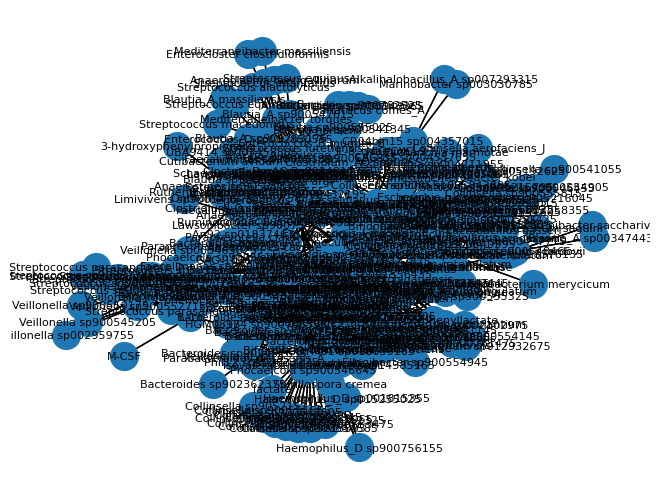

In [180]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added 
#youre threshold here can dictate what happens below
networkset=networkset.loc[ (abs(networkset['value']) > 0) &  (networkset['var1'] != networkset['var2']) ]

nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]
#build the graph using networkx lib
# G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
# pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)

# nx.draw(G, pos=pos)



# nx.draw_networkx_labels(G, pos=pos)
# plt.show()



G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.1))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True,  node_size=400,  linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.1))


## NOTE THAT I WILL HAVE TO KEEP RERUNNING THE GRAPH ABOVE IN ORDER TO CHANGE MY FILTERS TO PROTEO, BIFIDO ECT.. NEED TO CHANGE VARIABEL NAMES IS THE ISSUE. AS I PLAY WITH STUFF AND BEGIN TO GET A STANDATRD PLOT WE ALL LIKE TO SEE I WILL WRITE A SCRITP TO JUST GENERATE THE PLOT

<AxesSubplot:>

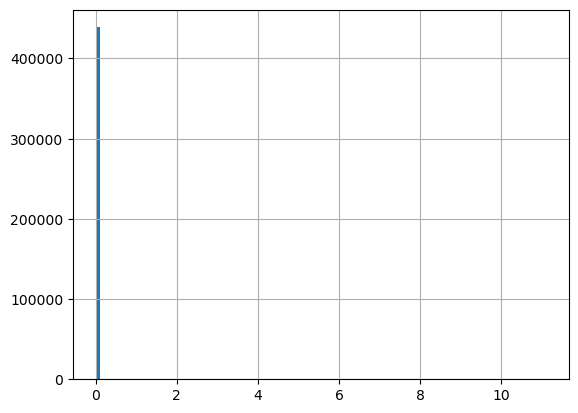

In [181]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
abs(links['value']).hist(bins=100)

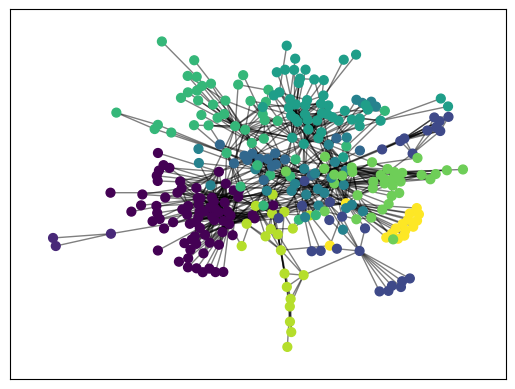

In [182]:
partition = community_louvain.best_partition(G)
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [183]:
binfantis = permutation_community_cluster('Bifidobacterium infantis', G, 800, 50)


In [184]:
search_for = binfantis

In [185]:
search_for

['Bifidobacterium adolescentis',
 'Bifidobacterium angulatum',
 'Bifidobacterium pseudocatenulatum',
 'Bifidobacterium ruminantium',
 'Bifidobacterium sp002742445',
 'Bifidobacterium sp012932675',
 'Gemmiger sp900554145',
 'Klebsiella pneumoniae',
 'Bifidobacterium catenulatum',
 'Bifidobacterium breve',
 'Bifidobacterium infantis',
 'Bifidobacterium kashiwanohense_A',
 'Bifidobacterium reuteri',
 'Bifidobacterium kashiwanohense',
 'Bifidobacterium myosotis',
 'Blautia_A sp900549015',
 'Caulobacter sp003931565',
 'Veillonella_A seminalis',
 '4-hydroxyphenyllactate',
 'indole-3-lactate',
 'Clostridium paraputrificum',
 'Klebsiella variicola',
 'Bifidobacterium merycicum',
 'Choladocola sp018376135',
 'Klebsiella africana']

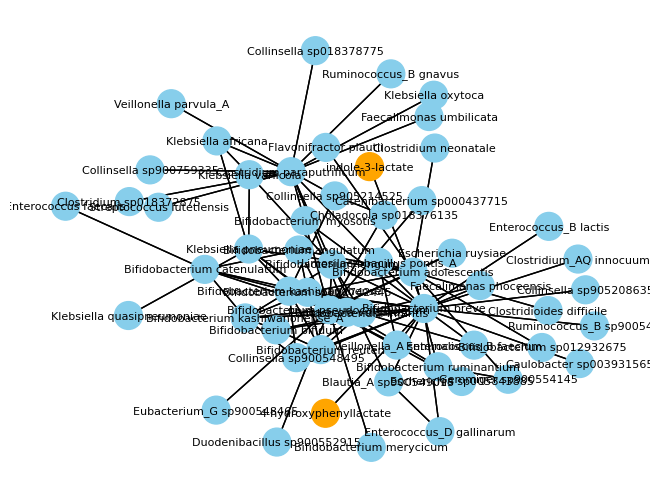

In [186]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added
networkset=networkset.loc[ (abs(networkset['value']) > 0) &  (networkset['var1'] != networkset['var2']) ]

colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) | (networkset['var2'].str.contains('|'.join(search_for)))]


nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]

## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color="black", linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


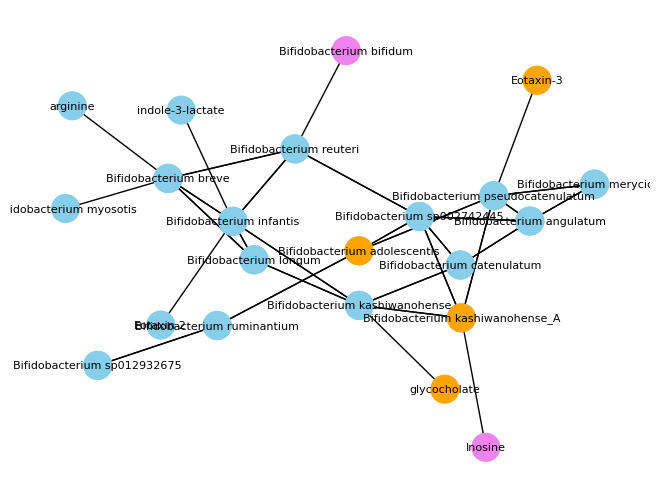

In [131]:
# you have ot continously go back to your old wasy of doing thinks

p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added
networkset=networkset.loc[ (abs(networkset['value']) > 0.18) &  (networkset['var1'] != networkset['var2']) ]

colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 
# networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) | (networkset['var2'].str.contains('|'.join(search_for)))]
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for)))]


nodes = list(networkset['var1'].unique()) + list(networkset['var2'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]

## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color="black", linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))



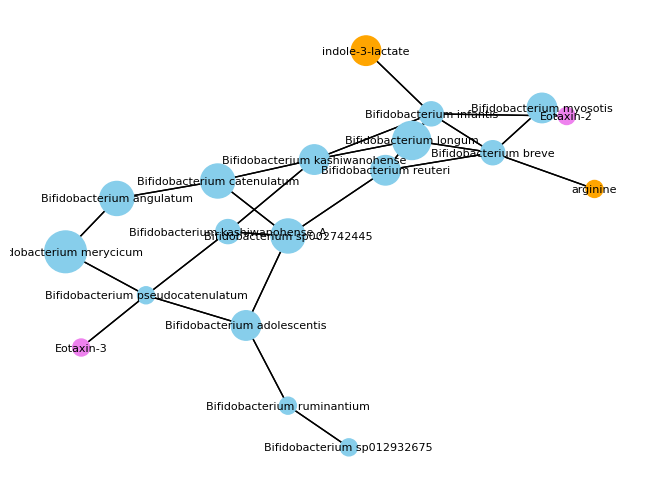

In [31]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added
networkset=networkset.loc[ (abs(networkset['value']) > 0.2) &  (networkset['var1'] != networkset['var2']) ]

colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) | (networkset['var2'].str.contains('|'.join(search_for)))]


nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]

## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')
d = dict(G.degree)

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=[v * 150 for v in d.values()], edge_color="black", linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


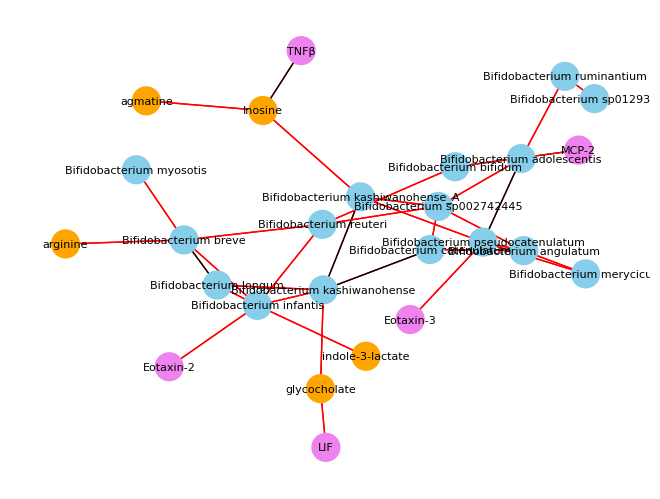

In [178]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added
networkset=networkset.loc[ (abs(networkset['value']) > 0.18) &  (networkset['var1'] != networkset['var2']) ]

colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) | (networkset['var2'].str.contains('|'.join(search_for)))]


nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]

## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.1))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


In [158]:
print(G.degree)

[('Bifidobacterium adolescentis', 3), ('Bifidobacterium pseudocatenulatum', 4), ('Bifidobacterium ruminantium', 2), ('Bifidobacterium sp002742445', 4), ('Bifidobacterium angulatum', 2), ('Bifidobacterium catenulatum', 3), ('Bifidobacterium merycicum', 2), ('Bifidobacterium breve', 5), ('Bifidobacterium infantis', 6), ('Bifidobacterium longum', 3), ('Bifidobacterium myosotis', 1), ('Bifidobacterium reuteri', 3), ('arginine', 1), ('Bifidobacterium kashiwanohense', 4), ('indole-3-lactate', 1), ('Eotaxin-2', 1), ('Bifidobacterium kashiwanohense_A', 3), ('Eotaxin-3', 1), ('Bifidobacterium sp012932675', 1), ('Inosine', 1), ('agmatine', 1), ('glycocholate', 1), ('LIF', 1)]


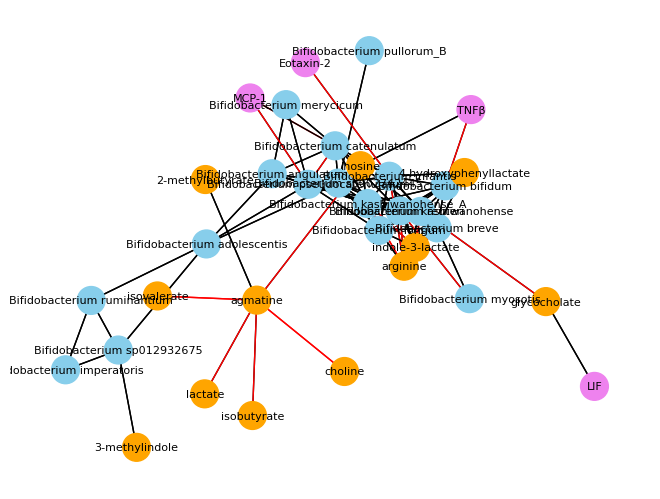

In [149]:
"""
Here we will once again focus on plotting based on both correlation coefficient and pvalue but with the addition that we will
now do a multiple test pvalue adjustment. Here I will add colors to the nodes to make them stand out if metabolite, taxa or immune
"""

search_for = binfantis

networkset = merge_corr_coef_pvalue_corr(species_metabolites_immune, pearson_species_metabolites_immune, corr_coef=0.3, pval=0.05)

# Change colors of edges depending of whether thereis a negative correlation or  positive correlation
colors = networkset['corr_coeff'].apply(lambda x: 'red' if x <0 else 'black') 


# only focus on bacteria ofinterest
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) | (networkset['var2'].str.contains('|'.join(search_for)))]

### this is addiitonal filtering done so we only focus on our subset df features of interest i.e. passed corr_coef and pvalue_corr
### thresholds. Also have the addition of filtering based on bifido. Will likely want ot change this later. 


nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]
## added



############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors
# change names to make betetr figure


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2')

nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


In [67]:
list(species_metabolites_immune.columns)

['Bifidobacterium adolescentis',
 'Bifidobacterium angulatum',
 'Bifidobacterium bifidum',
 'Bifidobacterium breve',
 'Bifidobacterium catenulatum',
 'Bifidobacterium dentium',
 'Bifidobacterium imperatoris',
 'Bifidobacterium infantis',
 'Bifidobacterium kashiwanohense',
 'Bifidobacterium kashiwanohense_A',
 'Bifidobacterium longum',
 'Bifidobacterium merycicum',
 'Bifidobacterium minimum',
 'Bifidobacterium moukalabense',
 'Bifidobacterium myosotis',
 'Bifidobacterium pseudocatenulatum',
 'Bifidobacterium pullorum_B',
 'Bifidobacterium pullorum_C',
 'Bifidobacterium reuteri',
 'Bifidobacterium ruminantium',
 'Bifidobacterium saguini',
 'Bifidobacterium scardovii',
 'Bifidobacterium sp002742445',
 'Bifidobacterium sp012932675',
 'Bifidobacterium sp018555355',
 'Bifidobacterium subtile',
 'Bacteroidota',
 'Firmicutes',
 'Proteobacteria',
 '2-methylbutyrate',
 '3-hydroxybenzoate',
 '3-hydroxyhippurate',
 '3-hydroxyphenylpropionate',
 '3-methylindole',
 '4-Ethylphenylsulfate',
 '4-ethylp

In [76]:
binfantis = permutation_community_cluster('Bacteroidota', G, 800, 50)


In [81]:
binfantis

['Bacteroidota',
 'I-309',
 '4-Ethylphenylsulfate',
 'MIP-1δ',
 'IL-1RA',
 'TARC',
 'TPO',
 'IL-16',
 'IL-21',
 'IL-28A',
 'Bifidobacterium myosotis',
 'Bifidobacterium subtile',
 'IL-17F',
 'IL-23',
 'IL-17E/IL-25',
 'TSLP',
 'TGFα',
 'IL-33']

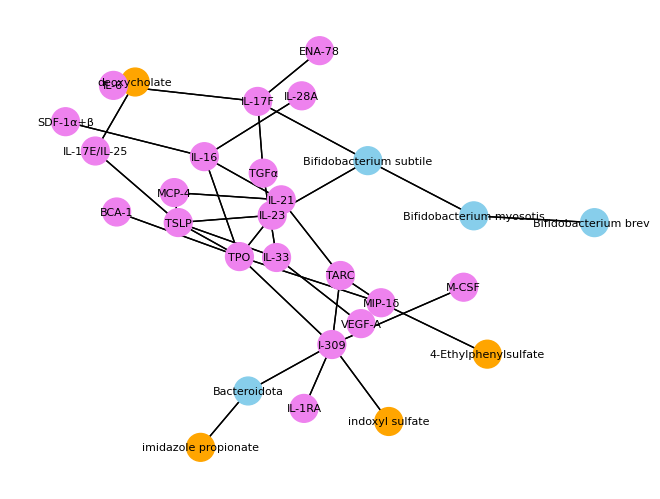

In [143]:

# binfantis = permutation_community_cluster('Bacteroidota', G, 800, 50)
search_for = binfantis
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added
networkset=networkset.loc[ (abs(networkset['value']) > 0.18) &  (networkset['var1'] != networkset['var2']) ]

colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) | (networkset['var2'].str.contains('|'.join(search_for)))]


nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]

## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color="black", linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


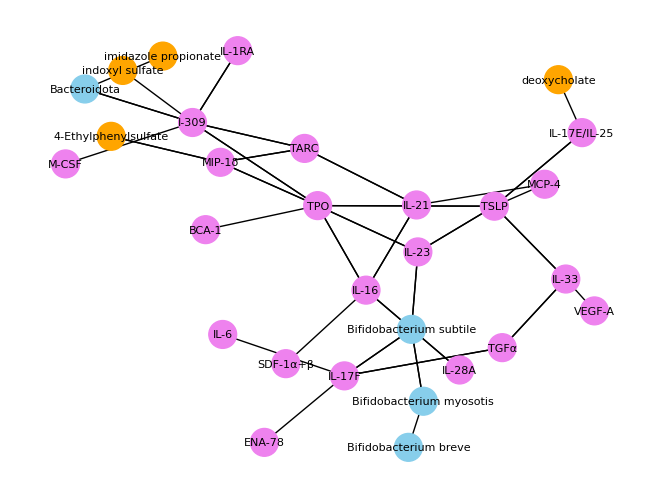

In [151]:

# binfantis = permutation_community_cluster('Bacteroidota', G, 800, 50)
search_for = binfantis
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added
networkset=networkset.loc[ (abs(networkset['value']) > 0.18) &  (networkset['var1'] != networkset['var2']) ]

colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) ]


# nodes = list(networkset['var1'].unique())
nodes =[]
[nodes.append(x) for x in (list(networkset['var1'].unique()) +list(networkset['var2'].unique())) if x not in nodes]
edges = [tuple(i) for i in networkset[['var1','var2']].values]

## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color="black", linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


In [101]:
# binfantis = permutation_community_cluster('Firmicutes', G, 800, 50)
partition = community_louvain.best_partition(G)
partition_lovian = pd.DataFrame(partition.items(), columns=['Name', 'Values'])
# feat_comm=partition_lovian[partition_lovian['Name']=='Firmicutes']['Values'].values[0]
# feat_comm
partition_lovian

Name  Values
0      Bifidobacterium breve       0
1   Bifidobacterium myosotis       0
2    Bifidobacterium subtile       0
3                     IL-17F       1
4                      IL-23       5
5               Bacteroidota       4
6       imidazole propionate       4
7                      I-309       4
8       4-Ethylphenylsulfate       3
9                     MIP-1δ       3
10              deoxycholate       5
11              IL-17E/IL-25       5
12           indoxyl sulfate       4
13                    IL-1RA       4
14                      IL-6       1
15                      TSLP       5
16                      TGFα       1
17                    ENA-78       1
18                     M-CSF       4
19                     IL-33       1
20                    VEGF-A       1
21                     BCA-1       5
22                       TPO       5
23                      TARC       3
24                     IL-16       2
25                     IL-21       2
26                    IL-28A       2
27                  SDF-1α+β       2
28                     MCP-4       2

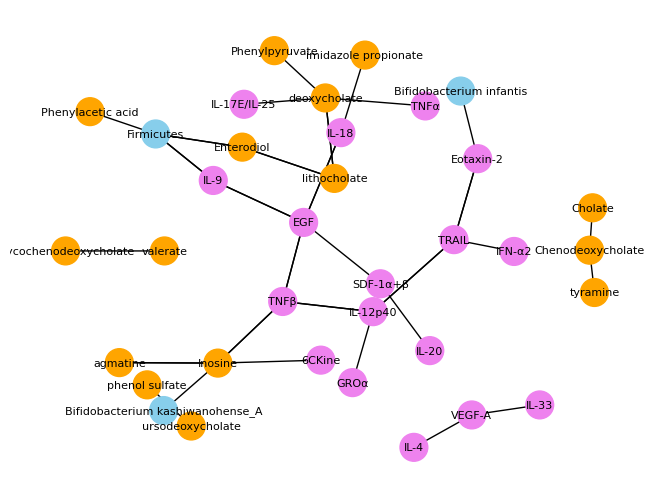

In [189]:

# binfantis = permutation_community_cluster('Firmicutes', G, 800, 50)

search_for = binfantis
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added
networkset=networkset.loc[ (abs(networkset['value']) > 0.18) &  (networkset['var1'] != networkset['var2']) ]

colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) ]


# nodes = list(networkset['var1'].unique())
nodes =[]
[nodes.append(x) for x in (list(networkset['var1'].unique()) +list(networkset['var2'].unique())) if x not in nodes]
edges = [tuple(i) for i in networkset[['var1','var2']].values]

## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color="black", linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


In [161]:
binfantis

['Eotaxin-2',
 'Firmicutes',
 'Enterodiol',
 'IL-9',
 'lithocholate',
 'Inosine',
 'agmatine',
 'TNFβ',
 'deoxycholate',
 'EGF',
 'SDF-1α+β',
 'IL-12p40',
 'TRAIL',
 'IL-20',
 'IL-18']

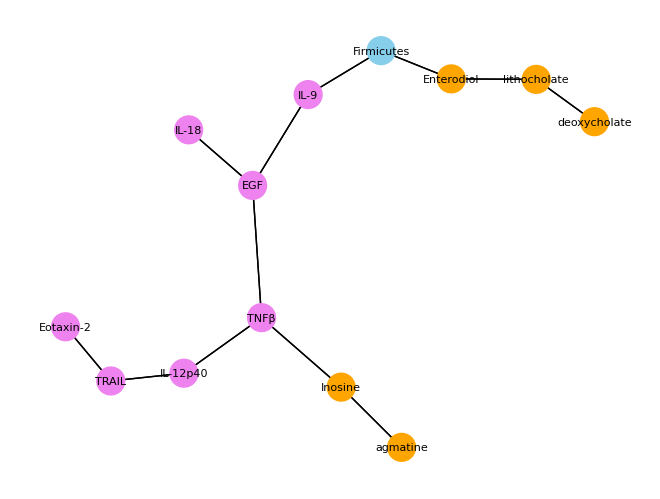

In [166]:
search_for = binfantis

p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

# ## added
networkset=networkset.loc[ (abs(networkset['value']) > 0.18) &  (networkset['var1'] != networkset['var2']) ]

# networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) & (networkset['var1'].str.contains('|'.join(search_for))) ]
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) ]
networkset = networkset[(networkset['var2'].str.contains('|'.join(search_for))) ]

colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 
networkset
# nodes = list(networkset['var1'].unique())
nodes =[]
[nodes.append(x) for x in (list(networkset['var1'].unique()) +list(networkset['var2'].unique())) if x not in nodes]
edges = [tuple(i) for i in networkset[['var1','var2']].values]

## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color="black", linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


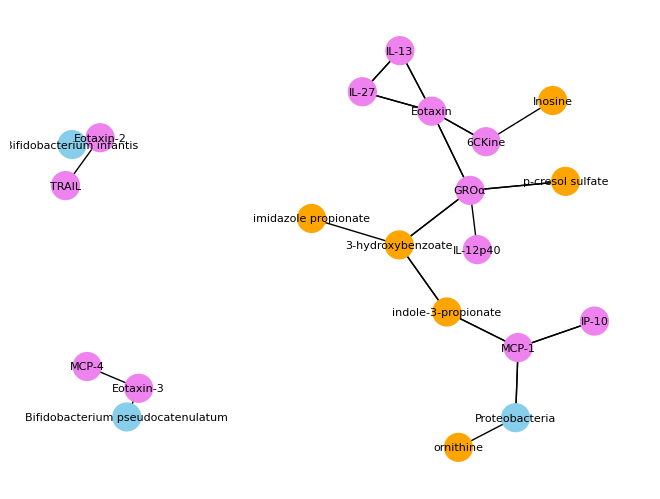

In [217]:

# binfantis = permutation_community_cluster('Proteobacteria', G, 800, 50)

search_for = binfantis
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added
networkset=networkset.loc[ (abs(networkset['value']) > 0.18) &  (networkset['var1'] != networkset['var2']) ]

colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) ]


# nodes = list(networkset['var1'].unique())
nodes =[]
[nodes.append(x) for x in (list(networkset['var1'].unique()) +list(networkset['var2'].unique())) if x not in nodes]
edges = [tuple(i) for i in networkset[['var1','var2']].values]

## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color="black", linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


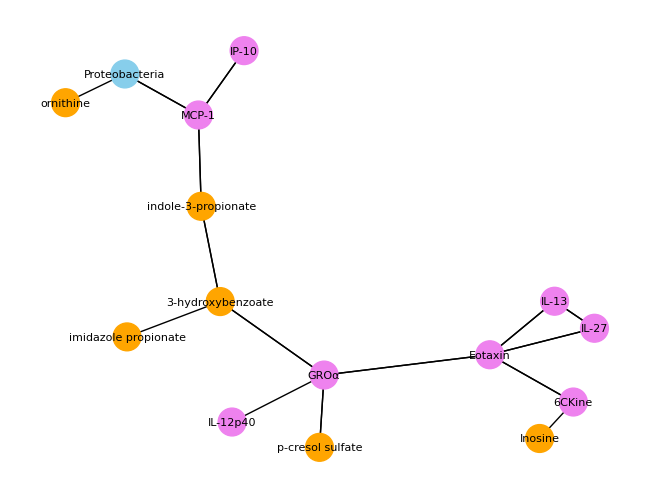

In [247]:

# binfantis = permutation_community_cluster('Proteobacteria', G, 800, 50)

search_for = binfantis
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added
networkset=networkset.loc[ (abs(networkset['value']) > 0.18) &  (networkset['var1'] != networkset['var2']) ]

networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) ]
filte=[ 'Eotaxin-2', 'Eotaxin-3','Bifidobacterium infantis','TRAIL','MCP4','Bifidobacterium pseudocatenulatum']
networkset = networkset[~(networkset['var1'].str.contains('|'.join(filte))) ]
networkset = networkset[~(networkset['var2'].str.contains('|'.join(filte))) ]

# nodes = list(networkset['var1'].unique())
nodes =[]
[nodes.append(x) for x in (list(networkset['var1'].unique()) +list(networkset['var2'].unique())) if x not in nodes]
edges = [tuple(i) for i in networkset[['var1','var2']].values]


# edges.remove(('Eotaxin-2', 'Bifidobacterium infantis'))
# edges.remove( ('Eotaxin-2', 'TRAIL'))
# edges.remove( ('Eotaxin-3', 'Bifidobacterium pseudocatenulatum'))
# edges.remove( ('Eotaxin-3', 'MCP-4'))

# nodes.remove( 'Eotaxin-2')
# nodes.remove( 'Eotaxin-3')
# nodes.remove('Bifidobacterium infantis')
# nodes.remove( 'TRAIL')
# nodes.remove('Bifidobacterium pseudocatenulatum')
# nodes.remove( 'MCP-4')


## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors
colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))
nx.draw(G,edgelist = edges, nodelist=nodes,
        with_labels=True, node_color=node_colors, node_size=400, edge_color="black", linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


var1                  var2     value
5100        Proteobacteria             ornithine  0.191465
5154        Proteobacteria                 MCP-1 -0.304761
5442     3-hydroxybenzoate  imidazole propionate  0.245133
5445     3-hydroxybenzoate   indole-3-propionate -0.353627
5486     3-hydroxybenzoate                  GROα -0.353326
13455  indole-3-propionate     3-hydroxybenzoate -0.353627
13567  indole-3-propionate                 MCP-1  0.205529
16405     p-cresol sulfate                  GROα  0.271890
19806              Eotaxin                  GROα -0.329986
19823              Eotaxin                 IL-13 -0.280543
19830              Eotaxin                 IL-27 -0.201985
19846              Eotaxin                6CKine  0.211024
20794                 GROα     3-hydroxybenzoate -0.353326
20855                 GROα      p-cresol sulfate  0.271890
20874                 GROα               Eotaxin -0.329986
20895                 GROα              IL-12p40 -0.187695
23917                IL-13               Eotaxin -0.280543
23947                IL-13                 IL-27 -0.612834
25170                IL-27               Eotaxin -0.201985
25193                IL-27                 IL-13 -0.612834
25381                IP-10                 MCP-1  0.225651
25446                MCP-1        Proteobacteria -0.304761
25493                MCP-1   indole-3-propionate  0.205529
25559                MCP-1                 IP-10  0.225651
27969               6CKine               Inosine  0.190275
28034               6CKine               Eotaxin  0.211024

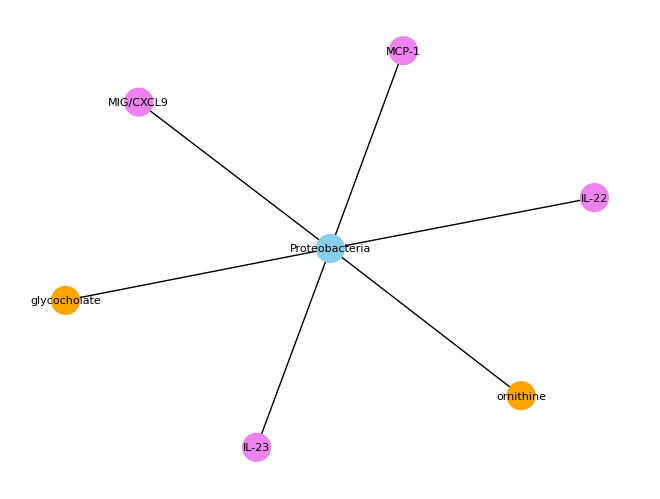

In [214]:
search_for = 'Proteobacteria'

p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

# ## added
networkset=networkset.loc[ (abs(networkset['value']) > 0.1) &  (networkset['var1'] != networkset['var2']) ]

# networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) & (networkset['var1'].str.contains('|'.join(search_for))) ]
networkset = networkset[(networkset['var1'].str.contains(search_for)) ]
# networkset = networkset[(networkset['var2'].str.contains('|'.join(search_for))) ]

colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 
networkset
# nodes = list(networkset['var1'].unique())
nodes =[]
[nodes.append(x) for x in (list(networkset['var1'].unique()) +list(networkset['var2'].unique())) if x not in nodes]
edges = [tuple(i) for i in networkset[['var1','var2']].values]

## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color="black", linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


In [192]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
binfantis_cov = links[(links['level_0'].str.contains('infantis')) & (abs(links[0])>0)]
# binfantis_cov.sort_values(0).to_csv('../Covariance_results_12052022/binfantis_covariance.csv')
binfantis_cov.sort_values(0)

level_0                           level_1         0
48475  Bifidobacterium infantis            Bifidobacterium longum -0.055168
48470  Bifidobacterium infantis             Bifidobacterium breve -0.041759
48473  Bifidobacterium infantis    Bifidobacterium kashiwanohense -0.020558
48481  Bifidobacterium infantis           Bifidobacterium reuteri -0.019337
48474  Bifidobacterium infantis  Bifidobacterium kashiwanohense_A -0.010906
48485  Bifidobacterium infantis       Bifidobacterium sp002742445 -0.010766
48581  Bifidobacterium infantis           Collinsella sp900548495 -0.006988
48469  Bifidobacterium infantis           Bifidobacterium bifidum -0.004254
48698  Bifidobacterium infantis           Faecalimonas phoceensis  0.000230
48672  Bifidobacterium infantis            Enterococcus_B faecium  0.007233
48472  Bifidobacterium infantis          Bifidobacterium infantis  0.181949

In [153]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
bacteroidota = links[(links['level_0'].str.contains('Bacteroidota')) & (abs(links[0])>0)]
bacteroidota.sort_values(0).to_csv('../Covariance_results_12052022/bacteroidota_covariance.csv')
bacteroidota.sort_values(0)


level_0                      level_1         0
4816  Bacteroidota                        I-309 -0.242650
4726  Bacteroidota         imidazole propionate -0.194517
4789  Bacteroidota                       IL-17A -0.151082
4734  Bacteroidota              indoxyl sulfate -0.128974
4819  Bacteroidota                        IL-21 -0.085229
4664  Bacteroidota       Bifidobacterium longum -0.083804
4830  Bacteroidota                          TPO -0.053736
4671  Bacteroidota   Bifidobacterium pullorum_C -0.048169
4743  Bacteroidota                     p-cresol -0.021604
4764  Bacteroidota                      Eotaxin -0.021384
4725  Bacteroidota                    hippurate -0.005093
4660  Bacteroidota  Bifidobacterium imperatoris  0.002894
4729  Bacteroidota          indole-3-propionate  0.005371
4675  Bacteroidota    Bifidobacterium scardovii  0.006174
4798  Bacteroidota                        M-CSF  0.007421
4666  Bacteroidota      Bifidobacterium minimum  0.024452
4775  Bacteroidota                       IL-1RA  0.024538
4739  Bacteroidota                      lactate  0.024848
4788  Bacteroidota                        IL-15  0.027762
4696  Bacteroidota                   Enterodiol  0.037222
4717  Bacteroidota                    carnitine  0.050274
4720  Bacteroidota                    citulline  0.098558
4762  Bacteroidota                       sCD40L  0.124764
4746  Bacteroidota                       phenol  0.132859
4680  Bacteroidota                 Bacteroidota  1.298539

In [190]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
Firmicutes = links[(links['level_0'].str.contains('Firmicutes')) & (abs(links[0])>0)]
Firmicutes.sort_values(0).to_csv('../Covariance_results_12052022/Firmicutes_covariance.csv')
Firmicutes.sort_values(0)


level_0                  level_1         0
4962  Firmicutes                     IL-9 -0.280360
4883  Firmicutes        Phenylacetic acid -0.181045
4909  Firmicutes            indoleacetate -0.172955
4894  Firmicutes                 butyrate -0.115424
4954  Firmicutes                   IL-1RA -0.096155
4952  Firmicutes                    IL-1α -0.075065
4947  Firmicutes                    G-CSF -0.036908
4934  Firmicutes    trimethylamine  (TMA) -0.027414
5002  Firmicutes                      LIF  0.000076
5006  Firmicutes                      SCF  0.005096
4886  Firmicutes           Phenylpyruvate  0.006923
4918  Firmicutes                  lactate  0.012326
4893  Firmicutes                  betaine  0.034067
4876  Firmicutes            Enterolactone  0.046288
4930  Firmicutes            phenyllactate  0.055845
4835  Firmicutes  Bifidobacterium bifidum  0.081508
4911  Firmicutes           indoleacrylate  0.128410
4871  Firmicutes   4-hydroxyphenyllactate  0.129141
4875  Firmicutes               Enterodiol  0.232685
4860  Firmicutes               Firmicutes  1.512039

In [248]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
Proteobacteria = links[(links['level_0'].str.contains('Proteobacteria')) & (abs(links[0])>0)]
Proteobacteria.sort_values(0)
Proteobacteria.sort_values(0).to_csv('../Covariance_results_12052022/Proteobacteria_covariance.csv')
Proteobacteria.sort_values(0)


level_0                     level_1         0
5154  Proteobacteria                       MCP-1 -0.304761
5158  Proteobacteria                   MIG/CXCL9 -0.153457
5081  Proteobacteria                glycocholate -0.109436
5090  Proteobacteria              indoleacrylate -0.062106
5147  Proteobacteria                      IL-17A -0.051871
5160  Proteobacteria                      MIP-1β -0.040340
5104  Proteobacteria                      phenol -0.016942
5095  Proteobacteria                  kynurenate -0.010381
5089  Proteobacteria         indoleacetylglycine -0.004673
5127  Proteobacteria                      GM-CSF  0.002848
5023  Proteobacteria   Bifidobacterium merycicum  0.003156
5017  Proteobacteria     Bifidobacterium dentium  0.009186
5184  Proteobacteria                      MIP-1δ  0.009993
5041  Proteobacteria            2-methylbutyrate  0.017969
5103  Proteobacteria            p-cresol sulfate  0.033515
5075  Proteobacteria                   carnitine  0.074417
5101  Proteobacteria                    p-cresol  0.083144
5114  Proteobacteria                  tryptamine  0.087737
5028  Proteobacteria  Bifidobacterium pullorum_B  0.088889
5178  Proteobacteria                       IL-23  0.105748
5151  Proteobacteria                       IL-22  0.152655
5100  Proteobacteria                   ornithine  0.191465
5040  Proteobacteria              Proteobacteria  1.303557

# will remove above here

# making networks

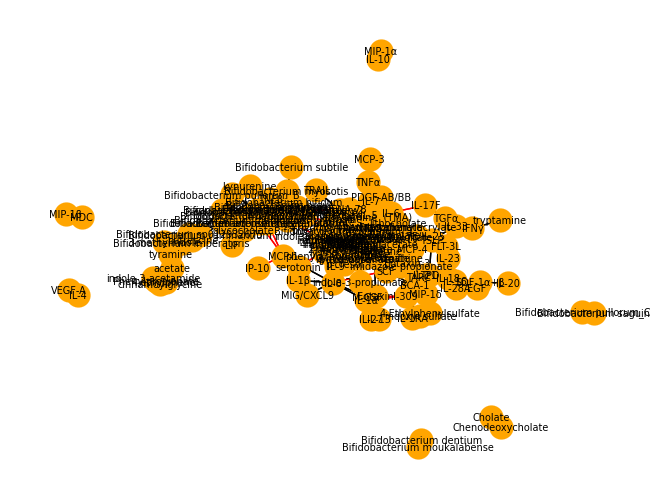

In [12]:
networkset = merge_corr_coef_pvalue_corr(species_metabolites_immune, pearson_species_metabolites_immune, corr_coef=0.3, pval=0.05)
nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]

# Change colors of edges depending of whether thereis a negative correlation or  positive correlation
colors = networkset['corr_coeff'].apply(lambda x: 'red' if x <0 else 'black') 


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2')

nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color='orange', node_size=300, edge_color=colors, linewidths=0.1, font_size=7,pos=nx.spring_layout(G, k=.1))


### Let us color based on categorical feature (taxa, metabolite , immune) 

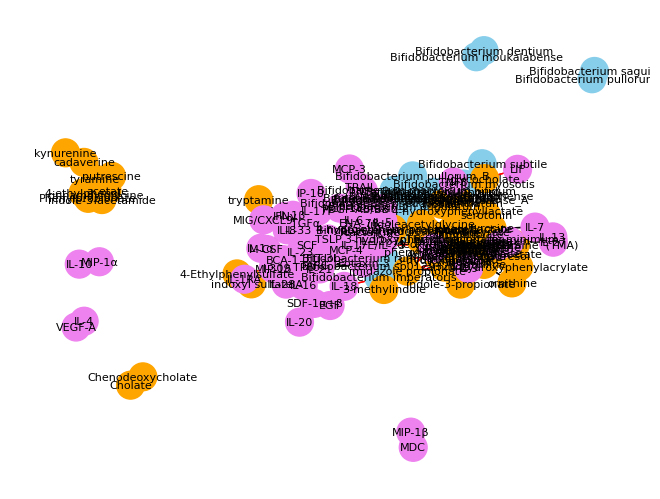

In [13]:
nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]
## added


# Change colors of edges depending of whether thereis a negative correlation or  positive correlation
colors = networkset['corr_coeff'].apply(lambda x: 'red' if x <0 else 'black') 

############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors
# change names to make betetr figure
G=nx.from_pandas_edgelist(networkset, 'var1', 'var2')

nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.1))


## Create modules in general 

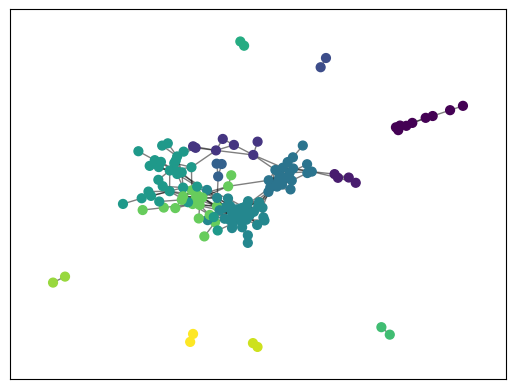

In [14]:
partition = community_louvain.best_partition(G,random_state=100)
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [15]:
# explore a bit 
partition = community_louvain.best_partition(G)
partition_lovian = pd.DataFrame(partition.items(), columns=['Name', 'Values'])
partition_lovian[partition_lovian['Name'].str.contains('Bifido')].sort_values('Values')

Name  Values
0        Bifidobacterium adolescentis       0
33         Bifidobacterium pullorum_B       0
32            Bifidobacterium subtile       0
18           Bifidobacterium myosotis       0
17     Bifidobacterium kashiwanohense       0
13            Bifidobacterium reuteri       0
12             Bifidobacterium longum       0
10              Bifidobacterium breve       0
9             Bifidobacterium bifidum       0
11           Bifidobacterium infantis       0
7    Bifidobacterium kashiwanohense_A       0
6         Bifidobacterium catenulatum       0
4         Bifidobacterium sp002742445       0
2   Bifidobacterium pseudocatenulatum       0
1           Bifidobacterium angulatum       0
8           Bifidobacterium merycicum       0
5         Bifidobacterium sp012932675       1
3         Bifidobacterium ruminantium       1
24        Bifidobacterium imperatoris       1
22            Bifidobacterium dentium       3
23       Bifidobacterium moukalabense       3
27            Bifidobacterium minimum       5
34         Bifidobacterium pullorum_C       6
35            Bifidobacterium saguini       6

In [63]:
binfantis = permutation_community_cluster('Bifidobacterium infantis', G, 800, 50)


## Focus on a specific feature and its community - in this case B. infantis. Selecting modules can have a bit of a randomness in its calculation. Weaker features will appear and dissapear with each iteration. Let's use a permutational approach to get community confidence

In [16]:
binfantis = permutation_community_cluster('Bifidobacterium infantis', G, 800, 50)


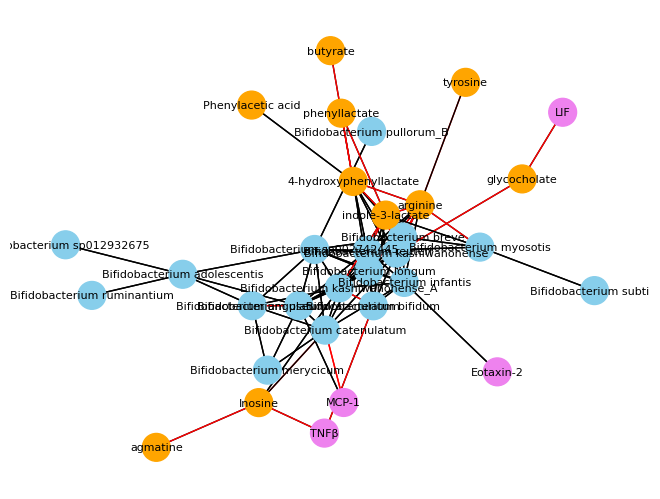

In [19]:
"""
Here we will once again focus on plotting based on both correlation coefficient and pvalue but with the addition that we will
now do a multiple test pvalue adjustment. Here I will add colors to the nodes to make them stand out if metabolite, taxa or immune
"""

search_for = binfantis

networkset = merge_corr_coef_pvalue_corr(species_metabolites_immune, pearson_species_metabolites_immune, corr_coef=0.3, pval=0.05)

# Change colors of edges depending of whether thereis a negative correlation or  positive correlation
colors = networkset['corr_coeff'].apply(lambda x: 'red' if x <0 else 'black') 


# only focus on bacteria ofinterest
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) | (networkset['var2'].str.contains('|'.join(search_for)))]

### this is addiitonal filtering done so we only focus on our subset df features of interest i.e. passed corr_coef and pvalue_corr
### thresholds. Also have the addition of filtering based on bifido. Will likely want ot change this later. 


nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]
## added



############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors
# change names to make betetr figure


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2')

nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


# PCA

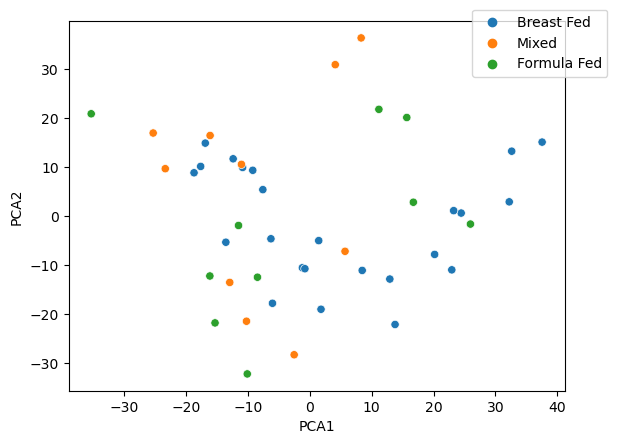

In [55]:
#using OG data alone 

dist_meta =  pd.merge(og_species_metabolites_immune.reset_index(),metadata_file[['BabyBio PBT','How was Baby Birthed?','Baby Feeding']], left_on='sample_id',right_on='BabyBio PBT')
dist_meta = dist_meta.set_index(['sample_id','How was Baby Birthed?','Baby Feeding']).drop(columns=['BabyBio PBT'])
dist_meta
# # do pca plot Species
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  #just focusing on the first 2 components
pc =  pca.fit_transform(dist_meta)
plot_df = pd.DataFrame(data = pc, columns = ['PCA1', 'PCA2'], index = dist_meta.index)

sns.scatterplot(x = 'PCA1', y = 'PCA2', hue = 'Baby Feeding', data = plot_df)
plt.legend(bbox_to_anchor=(1.1, 1.05))

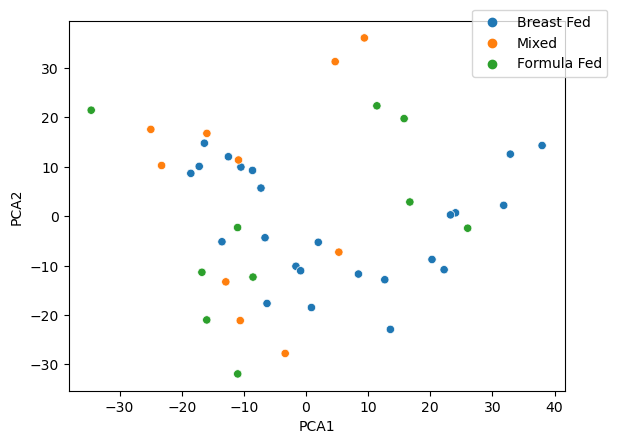

In [52]:
# using data with only signifant correlation
dist_meta =  pd.merge(species_metabolites_immune.reset_index(),metadata_file[['BabyBio PBT','How was Baby Birthed?','Baby Feeding']], left_on='sample_id',right_on='BabyBio PBT')
dist_meta = dist_meta.set_index(['sample_id','How was Baby Birthed?','Baby Feeding']).drop(columns=['BabyBio PBT'])
dist_meta
# # do pca plot Species
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  #just focusing on the first 2 components
pc =  pca.fit_transform(dist_meta)
plot_df = pd.DataFrame(data = pc, columns = ['PCA1', 'PCA2'], index = dist_meta.index)

sns.scatterplot(x = 'PCA1', y = 'PCA2', hue = 'Baby Feeding', data = plot_df)
plt.legend(bbox_to_anchor=(1.1, 1.05))

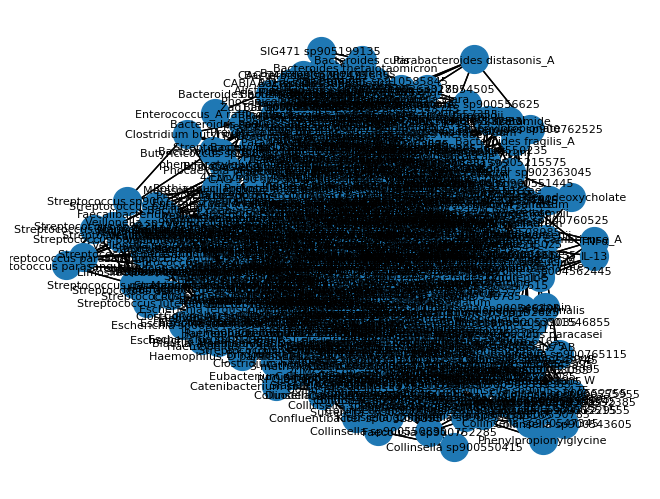

In [221]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added 
#youre threshold here can dictate what happens below
networkset=networkset.loc[ (abs(networkset['value']) > 0) &  (networkset['var1'] != networkset['var2']) ]

nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]
#build the graph using networkx lib
# G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
# pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)

# nx.draw(G, pos=pos)



# nx.draw_networkx_labels(G, pos=pos)
# plt.show()



G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.1))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True,  node_size=400,  linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.1))



# partition = community_louvain.best_partition(G,random_state=100)
# # draw the graph
# pos = nx.spring_layout(G)
# # color the nodes according to their partition
# cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
# nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
#                        cmap=cmap, node_color=list(partition.values()))
# nx.draw_networkx_edges(G, pos, alpha=0.5)
# plt.show()

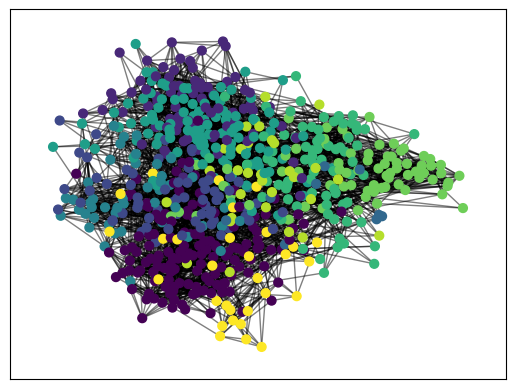

In [222]:
partition = community_louvain.best_partition(G,random_state=100, )
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [223]:


community_louvain.modularity(partition, G)

0.5656323616894705

In [65]:
partition_lovian = pd.DataFrame(partition.items(), columns=['Name', 'Values'])
partition_lovian_test = partition_lovian.copy()
partition_lovian_test['module_name'] = partition_lovian_test['Values'].apply(lambda x: 'module_' +str(x))
partition_lovian_test

partition_lovian_dict = dict(zip(partition_lovian_test.Name, partition_lovian_test.module_name))

print(len(partition_lovian_dict))
list(partition_lovian.Name)
species_metabolites_immune_sig_clusters = species_metabolites_immune[list(partition_lovian.Name)]
species_metabolites_immune_sig_clusters = species_metabolites_immune_sig_clusters.rename(columns = partition_lovian_dict).groupby(lambda x: x, axis =1).sum()
species_metabolites_immune_sig_clusters

663


module_0    module_1    module_2   module_3    module_4  \
sample_id                                                              
PBT-03005  -72.400169  -47.206723   82.156213   9.530488  124.149891   
PBT-03008   12.116863  -70.257081  -48.710708  -3.711130   -4.693793   
PBT-03015  162.446236  -67.703900  -31.801739   3.233249  -21.589906   
PBT-03016  -46.038443  -22.114957    3.115424  -2.729446   16.464675   
PBT-03017  184.962350  -28.737939  -81.939522  -3.327668   12.511064   
PBT-03021  196.867095  -83.394022  -70.120884   5.583548  -60.507770   
PBT-03024  184.562526  -60.356225  -55.703794  -0.869113   27.238921   
PBT-03026   83.620924 -108.032377   62.284811   4.302855  152.242408   
PBT-03029 -146.597274  -55.438721  -26.350142   2.941755  -24.922590   
PBT-03051  -29.139279  -29.412198   12.036832   3.809626  -16.731962   
PBT-03055  192.011429  -98.295900  -21.171576   1.459047   30.271762   
PBT-03056  273.049199 -114.343781  -42.534606   8.018016   63.804953   
PBT-03060   20.950351  -57.693684  -39.759353   9.449654   18.604290   
PBT-03061  -94.464365  -28.805327  -26.055136   5.263209  -38.816664   
PBT-03064 -135.014710  -73.534191  -35.869450  -1.750620  -35.826143   
PBT-03065  -52.616262   27.130176   68.687311   2.637565   33.856430   
PBT-03067  -80.256992  -51.987852  168.617032  11.669527  -23.936113   
PBT-03070  -60.112033  -10.134065  149.366673   6.519314  -21.938225   
PBT-03074 -132.197831  -89.639563  229.876917  10.087494  120.494039   
PBT-03075 -159.515733  118.364086   -9.564749   9.643859  -21.721946   
PBT-03076   56.184649  -86.411767  -51.739271   4.381326  -17.098737   
PBT-03078  -90.623450  -41.216625   38.500461   2.010601  -11.003197   
PBT-03084   78.467486 -110.579703   -8.175038   4.923743   72.575638   
PBT-03085   94.104241 -102.535360   -6.763865   2.237404   -9.412654   
PBT-03088  -87.553651  -45.827046  -44.389233  -1.815460  -34.387099   
PBT-03089  -67.929404  -40.800284  -42.990625   1.258819    2.986596   
PBT-03092  117.509389   19.364412 -106.152487   6.616993  -62.537444   
PBT-03098   -7.329139  -93.348586  -32.403192   5.561770   -6.750334   
PBT-03100 -153.331360   14.038116  -31.546330   3.037345  -58.103251   
PBT-03103  174.343468  -86.174716   -0.476391   5.434731  -23.005411   
PBT-03111  -62.228508  -23.680054   11.662338   2.433872   73.110856   
PBT-03112  -89.140256  -59.821777    5.359045   1.560256   78.978170   
PBT-03116    9.090268  -94.152226  -13.285578   4.398568   -9.492405   
PBT-03130 -174.165416 -103.680930  -33.362419   8.037973  -17.426970   
PBT-03143  -74.957016  -48.106428   81.840779  13.582186  -30.849095   
PBT-03145 -145.515011  -26.939669  -47.900659  -2.781925    4.170282   
PBT-03147  -56.416631  -87.807058   59.472483  -2.793771   81.762556   
PBT-03150  -73.708546    9.585124   42.818293  10.741370   37.672273   
PBT-03151  -38.920570   27.599952  -36.609096   4.967482  -35.942805   
PBT-03153 -138.765999  -69.015202   -4.537874   4.262948   51.866045   
PBT-03159 -125.900488   44.298083   -5.817901   0.853444   23.596143   
PBT-03174  192.287411  -96.853494  -17.389059   6.021631   63.704869   
PBT-03204 -125.026359  127.164810    4.659309   2.147258  -14.716411   
PBT-03217  -59.557640  -36.308149   77.963482   6.683700  -14.324471   

             module_5    module_6    module_7   module_8   module_9  
sample_id                                                            
PBT-03005    1.611901  -30.634522  -25.790881 -11.395408 -13.044310  
PBT-03008  -47.195865  165.077395   33.133054 -10.829538 -13.992179  
PBT-03015  -62.795090   62.283499  -30.692646 -19.204246  -8.018301  
PBT-03016   65.548548   13.458775  -45.439767 -10.819456  21.627901  
PBT-03017  103.246029  -75.607233  -74.906482 -16.033407  -8.314583  
PBT-03021  196.590191  -60.697148 -106.962261 -17.398280   8.156463  
PBT-03024  143.520642  -84.752561 -139.759173  -4.384280   3.842777  
PBT-03026  -56.096009  -22.136378  -67.449077 -11.120023 -17.733238  


In [66]:
partition_lovian_test[partition_lovian_test['Name'].str.contains('infantis')]

Name  Values module_name
368  Bifidobacterium infantis       6    module_6

In [67]:
list(partition_lovian_test[partition_lovian_test['module_name']=='module_6']['Name'])

['Clostridium neonatale',
 'Eubacterium_G sp900548465',
 'UMGS1590 sp900759105',
 'Bifidobacterium pseudocatenulatum',
 'Bifidobacterium merycicum',
 'Choladocola sp018376135',
 'Bifidobacterium saguini',
 'Paralachnospira sp902363445',
 'Slackia_A sp900553775',
 'Bifidobacterium pullorum_C',
 'Enterolactone',
 'IL-27',
 'Collinsella sp018378775',
 'Bifidobacterium adolescentis',
 'Bifidobacterium angulatum',
 'Bifidobacterium sp002742445',
 'Bifidobacterium catenulatum',
 'Bifidobacterium kashiwanohense_A',
 'Bifidobacterium breve',
 'Bifidobacterium reuteri',
 'Collinsella sp900548495',
 'Collinsella sp905215115',
 '4-hydroxyphenyllactate',
 'TNFβ',
 'Bifidobacterium infantis',
 'Bifidobacterium longum',
 'Bifidobacterium myosotis',
 'Caulobacter sp003931565',
 'Collinsella sp905208635',
 'Limosilactobacillus pontis_A',
 'arginine',
 'indole-3-lactate',
 'Bifidobacterium kashiwanohense',
 'Inosine',
 'Bifidobacterium sp018555355',
 'Collinsella sp900552425',
 'Collinsella sp900765185

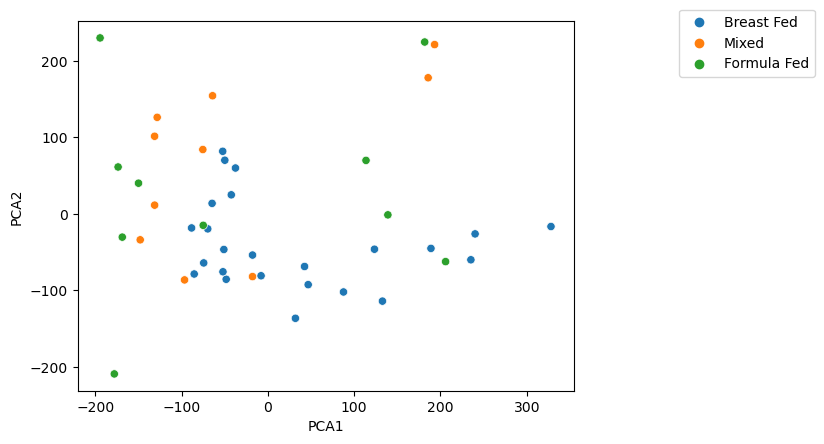

In [68]:

dist_meta =  pd.merge(species_metabolites_immune_sig_clusters.reset_index(),metadata_file[['BabyBio PBT','How was Baby Birthed?','Baby Feeding']], left_on='sample_id',right_on='BabyBio PBT')
dist_meta = dist_meta.set_index(['sample_id','How was Baby Birthed?','Baby Feeding']).drop(columns=['BabyBio PBT'])
dist_meta
# # do pca plot Species
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  #just focusing on the first 2 components
pc =  pca.fit_transform(dist_meta)
plot_df = pd.DataFrame(data = pc, columns = ['PCA1', 'PCA2'], index = dist_meta.index)

sns.scatterplot(x = 'PCA1', y = 'PCA2', hue = 'Baby Feeding', data = plot_df)
plt.legend(bbox_to_anchor=(1.5, 1.05))

663


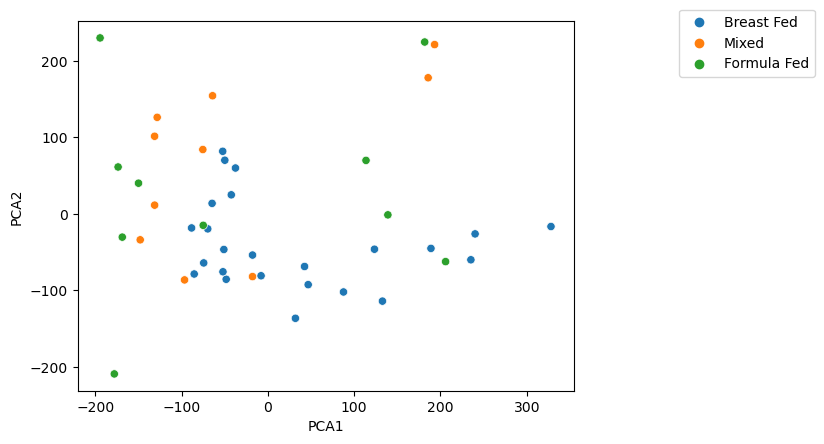

In [91]:
# species_metabolites_immune
# partition_lovian_dict = dict(zip(partition_lovian.Name, partition_lovian.Values))
partition_lovian_dict = dict(zip(partition_lovian_test.Name, partition_lovian_test.module_name))

print(len(partition_lovian_dict))
list(partition_lovian.Name)
species_metabolites_immune_sig_clusters = species_metabolites_immune[list(partition_lovian.Name)]
species_metabolites_immune_sig_clusters = species_metabolites_immune_sig_clusters.rename(columns = partition_lovian_dict).groupby(lambda x: x, axis =1).sum()
species_metabolites_immune_sig_clusters


dist_meta =  pd.merge(species_metabolites_immune_sig_clusters.reset_index(),metadata_file[['BabyBio PBT','How was Baby Birthed?','Baby Feeding']], left_on='sample_id',right_on='BabyBio PBT')
dist_meta = dist_meta.set_index(['sample_id','How was Baby Birthed?','Baby Feeding']).drop(columns=['BabyBio PBT'])
dist_meta
# # do pca plot Species
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  #just focusing on the first 2 components
pc =  pca.fit_transform((dist_meta))
plot_df = pd.DataFrame(data = pc, columns = ['PCA1', 'PCA2'], index = dist_meta.index)

sns.scatterplot(x = 'PCA1', y = 'PCA2', hue = 'Baby Feeding', data = plot_df)
plt.legend(bbox_to_anchor=(1.5, 1.05))

In [70]:
# get the contribution of each ASV to its respective PCA components
featimp = pd.DataFrame(pca.components_,columns=species_metabolites_immune_sig_clusters.columns,index = ['PC-1','PC-2'])

#transpose that df above and get absolute numbers for all. Idea is that negative and positive 
# eigenvalues simply tell you the direction of a given variable on the dimension vector. Since
# we are not interested in the direction but the total separation then gettign absolute for 
# PC1 and PC2 and summing the totals seems like the best approach. 
featimp_t = featimp.transpose().abs()

# In order to see  What are the top 5 microbes (in terms of ASV IDs) that contribute the most to the first 
# two principal components
merged = featimp_t['PC-1']+featimp_t['PC-2']
merged.sort_values(ascending=False)[:5]

module_0    1.001803
module_5    0.907222
module_6    0.696182
module_7    0.569446
module_1    0.482917
dtype: float64

In [166]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

dist_meta =  pd.merge(species_metabolites_immune_sig_clusters.reset_index(),metadata_file[['BabyBio PBT','How was Baby Birthed?','Baby Feeding']], left_on='sample_id',right_on='BabyBio PBT')
dist_meta = dist_meta.set_index(['sample_id']).drop(columns=['BabyBio PBT','How was Baby Birthed?','Baby Feeding'])

df = dist_meta

df
features = list(X.columns)
X = df[features]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=df.reset_index()['sample_id'])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [171]:
subset = species_metabolites_immune_sig_clusters.reset_index()[species_metabolites_immune_sig_clusters.reset_index()['sample_id']=='PBT-03056']
subset

sample_id    module_0    module_1   module_2  module_3   module_4  \
11  PBT-03056  273.049199 -114.343781 -42.534606  8.018016  63.804953   

     module_5   module_6  module_7  module_8  module_9  
11 -85.626295  28.631839 -95.23857 -9.661242  -3.55909

In [175]:
subset = species_metabolites_immune.reset_index()[species_metabolites_immune.reset_index()['sample_id']=='PBT-03056']
subset[['Bifidobacterium infantis']]

Bifidobacterium infantis
11                  4.578599

In [176]:
subset = species_metabolites_immune_sig_clusters.reset_index()[species_metabolites_immune_sig_clusters.reset_index()['sample_id']=='PBT-03089']
subset

sample_id   module_0   module_1   module_2  module_3  module_4   module_5  \
25  PBT-03089 -67.929404 -40.800284 -42.990625  1.258819  2.986596  19.534624   

      module_6   module_7  module_8  module_9  
25  196.498125 -50.423057  0.253237 -6.957096

In [177]:
subset = species_metabolites_immune.reset_index()[species_metabolites_immune.reset_index()['sample_id']=='PBT-03089']
subset[['Bifidobacterium infantis']]

Bifidobacterium infantis
25                  6.992657

In [250]:
meta_new = pd.read_csv('limited_annotated_metadata_p4.tsv', sep='\t')
dist_meta =  pd.merge(species_metabolites_immune_sig_clusters.reset_index(),meta_new[['sample_id','Feeding Mode','Birth Method','cluster']], left_on='sample_id',right_on='sample_id')
dist_meta = dist_meta.set_index(['cluster']).drop(columns=['sample_id','Feeding Mode','Birth Method'])
dist_meta
X=dist_meta
features = list(X.columns)
X = X[features]

pca = PCA(n_components=2)
components = pca.fit_transform(X)
X
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=X.reset_index()['cluster'])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
    
pca1= 'PCA1 (' +str(round(pca.explained_variance_ratio_[0]*100,2))+ "% expl. var)"
pca2= 'PCA2 (' +str(round(pca.explained_variance_ratio_[1]*100,2))+ "% expl. var)"

    
fig.update_layout(
    xaxis_title=pca1,
    yaxis_title=pca2,
    
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="#7f7f7f"
#     )
 )

fig.show()

# get the contribution of each ASV to its respective PCA components
featimp = pd.DataFrame(pca.components_,columns=species_metabolites_immune_sig_clusters.columns,index = ['PC-1','PC-2'])

#transpose that df above and get absolute numbers for all. Idea is that negative and positive 
# eigenvalues simply tell you the direction of a given variable on the dimension vector. Since
# we are not interested in the direction but the total separation then gettign absolute for 
# PC1 and PC2 and summing the totals seems like the best approach. 
featimp_t = featimp.transpose().abs()

# In order to see  What are the top 5 microbes (in terms of ASV IDs) that contribute the most to the first 
# two principal components
merged = featimp_t['PC-1']+featimp_t['PC-2']
print(merged.sort_values(ascending=False)[:5])

print(featimp)

module_0    1.001803
module_5    0.907222
module_6    0.696182
module_7    0.569446
module_1    0.482917
dtype: float64
      module_0  module_1  module_2  module_3  module_4  module_5  module_6  \
PC-1  0.894786 -0.210066 -0.137583 -0.001136  0.071555 -0.270034 -0.075957   
PC-2  0.107017  0.272851 -0.067343 -0.001676  0.001551  0.637188 -0.620225   

      module_7  module_8  module_9  
PC-1 -0.224755 -0.042674 -0.012508  
PC-2 -0.344691  0.007669  0.000889  


In [234]:
str(round(pca.explained_variance_ratio_[0]*100,2))

'41.32'

In [194]:
meta_new = pd.read_csv('limited_annotated_metadata_p4.tsv', sep='\t')

feat_keep = 'Feeding Mode'
dist_meta =  pd.merge(species_metabolites_immune_sig_clusters.reset_index(),meta_new[['sample_id',feat_keep]], left_on='sample_id',right_on='sample_id')
dist_meta = dist_meta.set_index([feat_keep]).drop(columns=['sample_id'])
dist_meta
X=dist_meta
features = list(X.columns)
X = X[features]

pca = PCA(n_components=2)
components = pca.fit_transform(X)
X
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=X.reset_index()[feat_keep])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [195]:
meta_new = pd.read_csv('limited_annotated_metadata_p4.tsv', sep='\t')

feat_keep = 'Birth Method'
dist_meta =  pd.merge(species_metabolites_immune_sig_clusters.reset_index(),meta_new[['sample_id',feat_keep]], left_on='sample_id',right_on='sample_id')
dist_meta = dist_meta.set_index([feat_keep]).drop(columns=['sample_id'])
dist_meta
X=dist_meta
features = list(X.columns)
X = X[features]

pca = PCA(n_components=2)
components = pca.fit_transform(X)
X
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=X.reset_index()[feat_keep])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

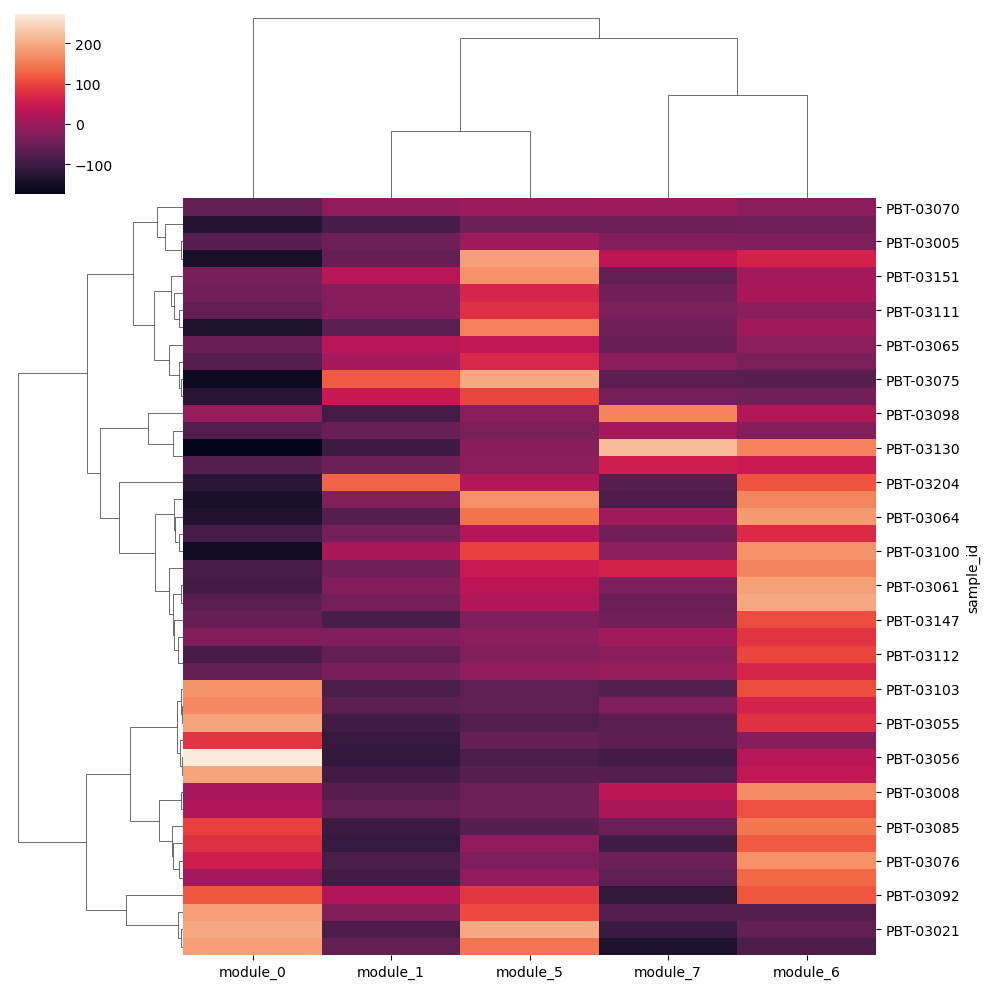

In [212]:
species_metabolites_immune_sig_clusters_sub = species_metabolites_immune_sig_clusters[['module_7',
                                                                                      'module_6',
                                                                                      'module_1',
                                                                                      'module_5',
                                                                                      'module_0']]
sns.clustermap(species_metabolites_immune_sig_clusters_sub, metric="correlation")

In [203]:
list(species_metabolites_immune_sig_clusters.columns)

['module_0',
 'module_1',
 'module_2',
 'module_3',
 'module_4',
 'module_5',
 'module_6',
 'module_7',
 'module_8',
 'module_9']

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [10] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[6]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


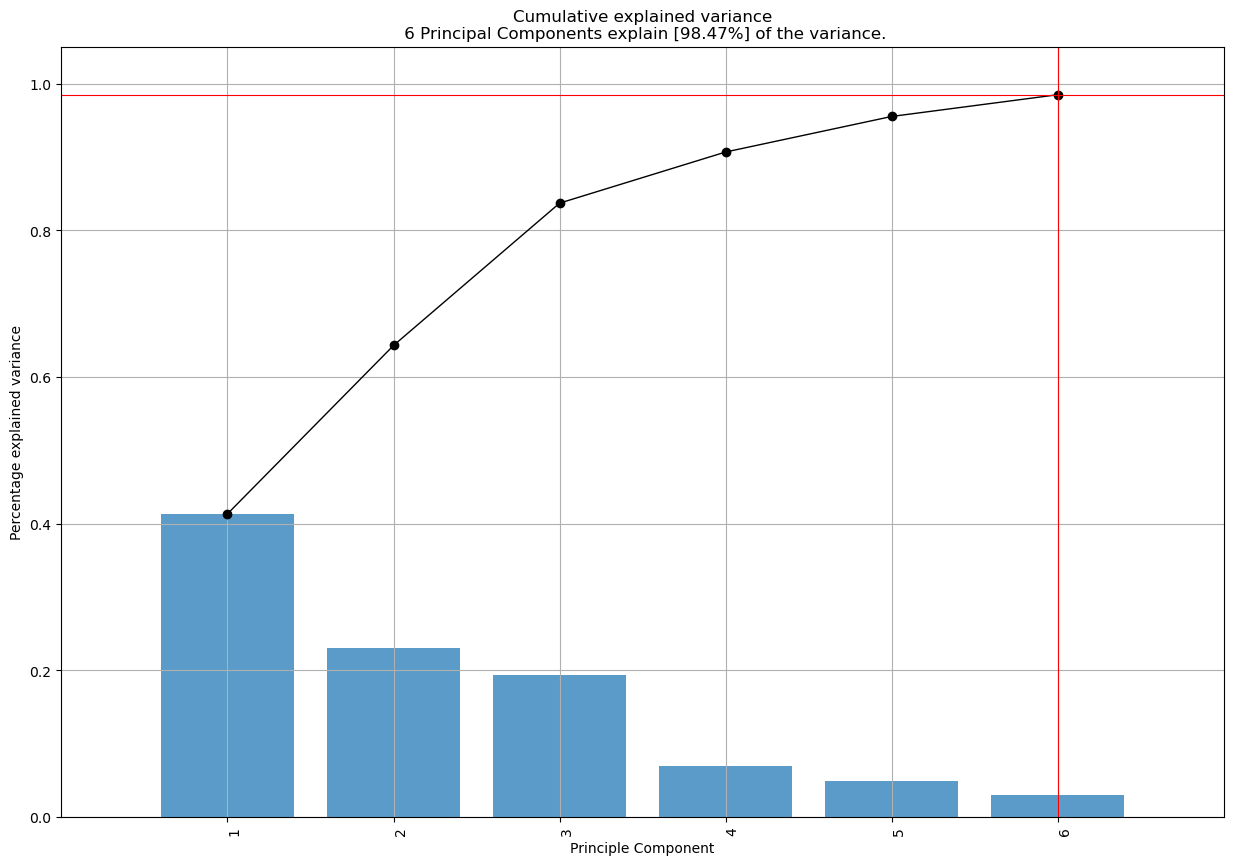

[pca] >Plot PC1 vs PC2 with loadings.


<Figure size 640x480 with 0 Axes>

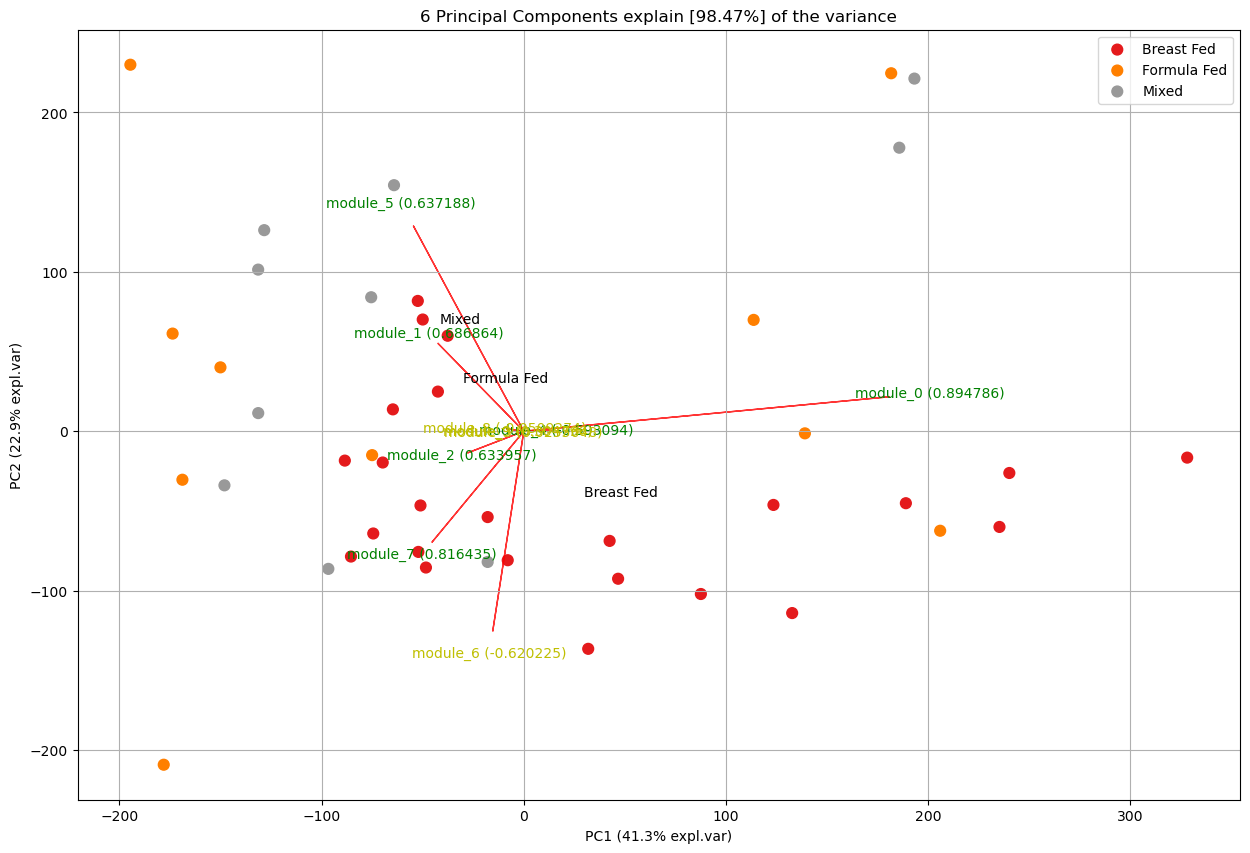

In [102]:
##TRY SOMETHING NEW

from pca import pca

# Initialize to reduce the data up to the number of componentes that explains 95% of the variance.
# model = pca(n_components=0.95)

# Or reduce the data towards 2 PCs
model = pca(n_components=6, normalize=False)

# Load example dataset
import pandas as pd
import sklearn


# dist_meta = pd.merge( metabolomics_metadata[['How was Baby Birthed?','Baby Feeding']].reset_index(), species_metabolites_immune_sig_clusters, 
#          left_on = 'sample_name', right_on='sample_name')
# dist_meta = dist_meta.set_index(['Baby Feeding'])
# dist_meta = dist_meta.drop(columns = ['How was Baby Birthed?','sample_name'])



dist_meta =  pd.merge(species_metabolites_immune_sig_clusters.reset_index(),metadata_file[['BabyBio PBT','How was Baby Birthed?','Baby Feeding']], left_on='sample_id',right_on='BabyBio PBT')
dist_meta = dist_meta.set_index(['Baby Feeding']).drop(columns=['BabyBio PBT','sample_id','How was Baby Birthed?'])
# dist_meta = dist_meta.drop(columns = ['How was Baby Birthed?','sample_id'])



X =dist_meta

# Fit transform
results = model.fit_transform(X)

# Plot explained variance
fig, ax = model.plot()

# # Make biplot with the number of features
fig, ax = model.biplot()


# fig, ax = model.biplot3d(n_feat=4)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [10] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[6]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


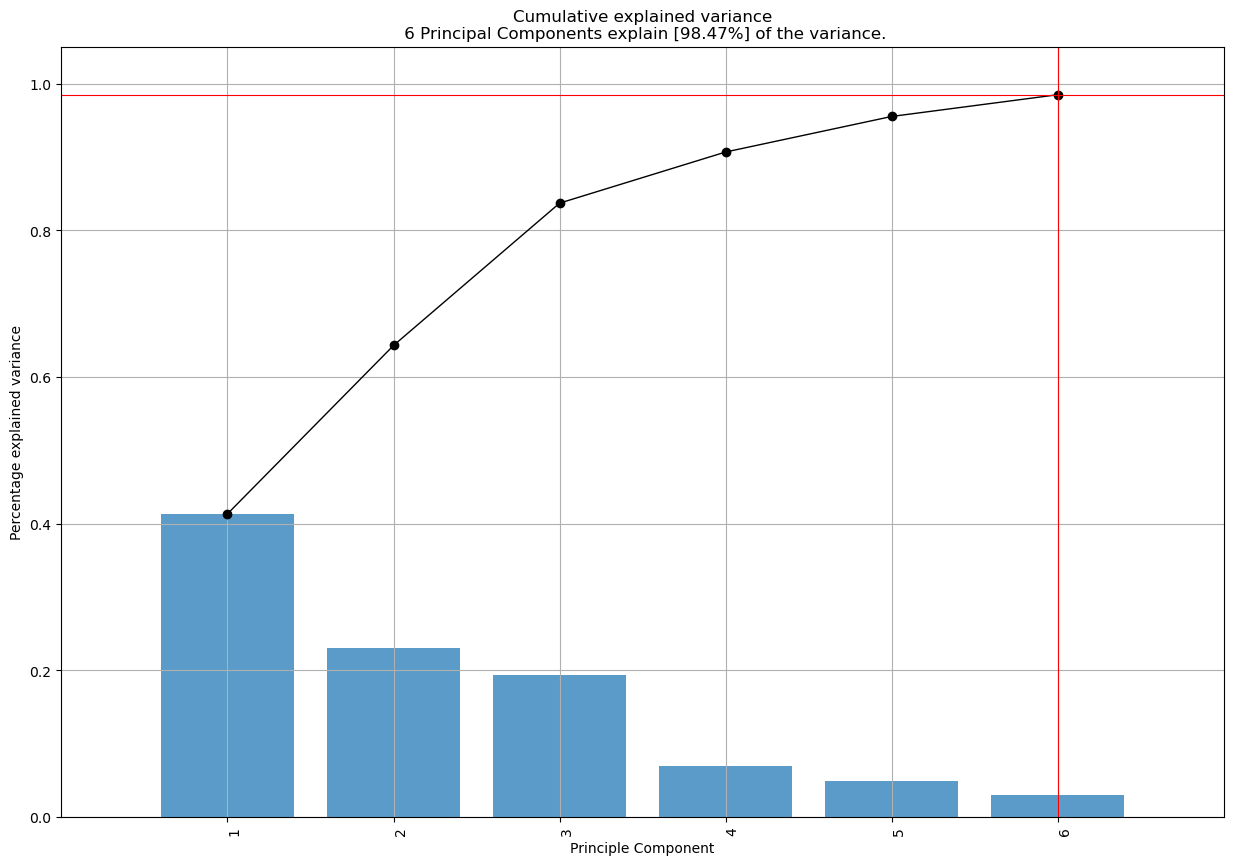

[pca] >Plot PC1 vs PC2 with loadings.


<Figure size 640x480 with 0 Axes>

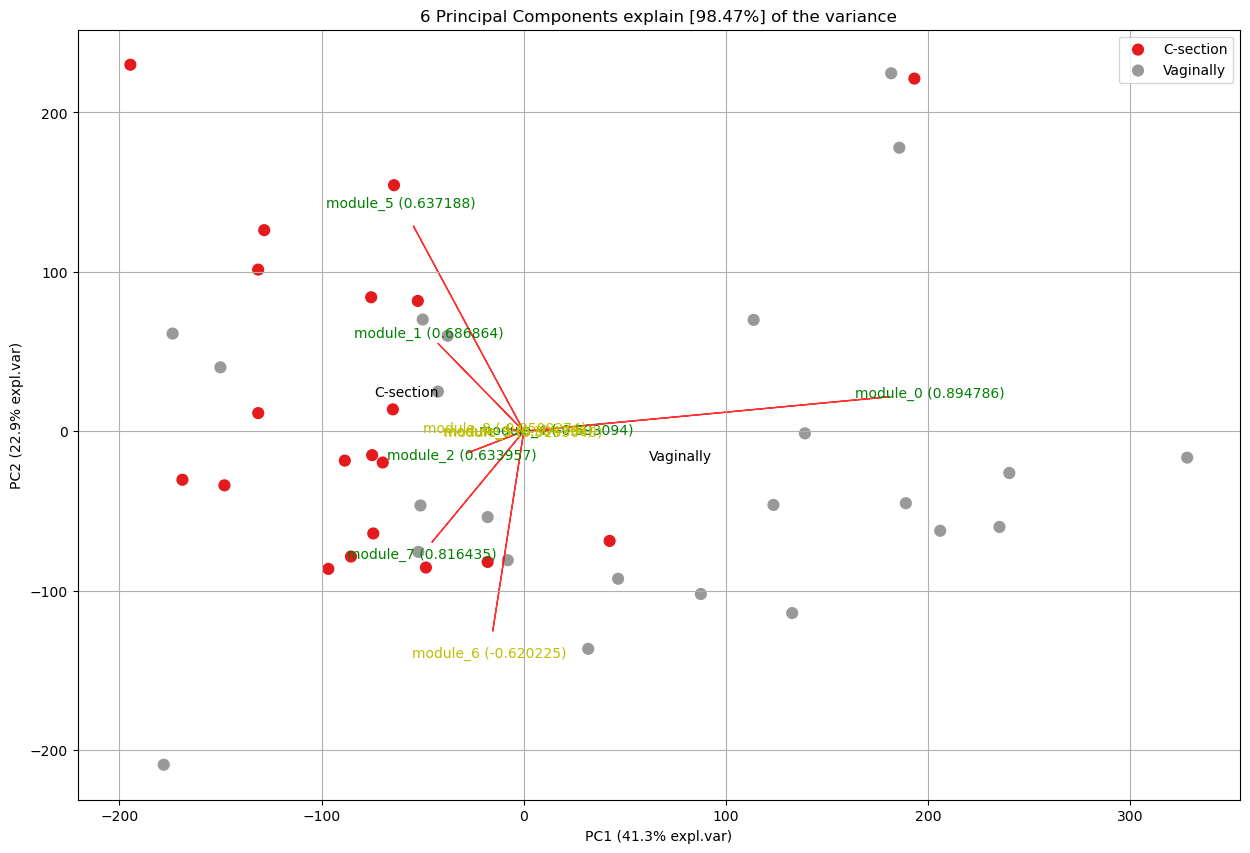

In [150]:
##TRY SOMETHING NEW

from pca import pca

# Initialize to reduce the data up to the number of componentes that explains 95% of the variance.
# model = pca(n_components=0.95)

# Or reduce the data towards 2 PCs
model = pca(n_components=6, normalize=False)

# Load example dataset
import pandas as pd
import sklearn


# dist_meta = pd.merge( metabolomics_metadata[['How was Baby Birthed?','Baby Feeding']].reset_index(), species_metabolites_immune_sig_clusters, 
#          left_on = 'sample_name', right_on='sample_name')
# dist_meta = dist_meta.set_index(['Baby Feeding'])
# dist_meta = dist_meta.drop(columns = ['How was Baby Birthed?','sample_name'])



dist_meta =  pd.merge(species_metabolites_immune_sig_clusters.reset_index(),metadata_file[['BabyBio PBT','How was Baby Birthed?','Baby Feeding']], left_on='sample_id',right_on='BabyBio PBT')
dist_meta = dist_meta.set_index(['How was Baby Birthed?']).drop(columns=['BabyBio PBT','sample_id','Baby Feeding'])
# dist_meta = dist_meta.drop(columns = ['How was Baby Birthed?','sample_id'])



X =dist_meta

# Fit transform
results = model.fit_transform(X)

# Plot explained variance
fig, ax = model.plot()

# # Make biplot with the number of features
fig, ax = model.biplot()


# fig, ax = model.biplot3d(n_feat=4)

In [147]:
merged.sort_values(ascending=False)[:]

module_0    1.001803
module_5    0.907222
module_6    0.696182
module_7    0.569446
module_1    0.482917
module_2    0.204926
module_4    0.073106
module_8    0.050344
module_9    0.013397
module_3    0.002812
dtype: float64

In [123]:
taxa = pd.read_csv('~/Desktop/Projects/hmo_clusters/abundance.tsv', sep='\t')
taxa = taxa[['name','gtdb_taxonomy']]
taxa[[0,"phylum",2,3,4,5,6]]=taxa.gtdb_taxonomy.str.split(";", expand=True,)
taxa=taxa[['name','phylum']]
taxa[['tmp','p']]=taxa['phylum'].str.split("__" ,expand=True,)
taxa =taxa[['name','p']]
taxa[['phylum',0]] = taxa['p'].str.split('_',expand=True,)
taxa = taxa[['name','phylum']]


In [130]:
taxa = pd.read_csv('~/Desktop/Projects/hmo_clusters/abundance.tsv', sep='\t')
taxa = taxa[['name','gtdb_taxonomy']]
taxa[[0,"phylum",2,3,4,5,6]]=taxa.gtdb_taxonomy.str.split(";", expand=True,)
# taxa=taxa[['name','phylum']]
# taxa[['tmp','p']]=taxa['phylum'].str.split("__" ,expand=True,)
# taxa =taxa[['name','p']]
# taxa[['phylum',0]] = taxa['p'].str.split('_',expand=True,)
taxa

name  \
0      Anaerosporobacter sp018372435   
1       Bifidobacterium adolescentis   
2            Bifidobacterium bifidum   
3              Bifidobacterium breve   
4           Bifidobacterium infantis   
...                              ...   
11838            UBA9414 sp018365895   
11839           UMGS1071 sp900542375   
11840           UMGS1540 sp900552775   
11841           UMGS1572 sp900553045   
11842        Veillonella sp900757715   

                                           gtdb_taxonomy            0  \
0      d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...  d__Bacteria   
1      d__Bacteria;p__Actinobacteriota;c__Actinomycet...  d__Bacteria   
2      d__Bacteria;p__Actinobacteriota;c__Actinomycet...  d__Bacteria   
3      d__Bacteria;p__Actinobacteriota;c__Actinomycet...  d__Bacteria   
4      d__Bacteria;p__Actinobacteriota;c__Actinomycet...  d__Bacteria   
...                                                  ...          ...   
11838  d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...  d__Bacteria   
11839  d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...  d__Bacteria   
11840  d__Bacteria;p__Firmicutes_A;c__Clostridia;o__U...  d__Bacteria   
11841  d__Bacteria;p__Firmicutes;c__Bacilli;o__RF39;f...  d__Bacteria   
11842  d__Bacteria;p__Firmicutes_C;c__Negativicutes;o...  d__Bacteria   

                    phylum                 2                   3  \
0          p__Firmicutes_A     c__Clostridia   o__Lachnospirales   
1      p__Actinobacteriota  c__Actinomycetia  o__Actinomycetales   
2      p__Actinobacteriota  c__Actinomycetia  o__Actinomycetales   
3      p__Actinobacteriota  c__Actinomycetia  o__Actinomycetales   
4      p__Actinobacteriota  c__Actinomycetia  o__Actinomycetales   
...                    ...               ...                 ...   
11838      p__Firmicutes_A     c__Clostridia   o__Lachnospirales   
11839      p__Firmicutes_A     c__Clostridia  o__Oscillospirales   
11840      p__Firmicutes_A     c__Clostridia         o__UMGS1883   
11841        p__Firmicutes        c__Bacilli             o__RF39   
11842      p__Firmicutes_C  c__Negativicutes   o__Veillonellales   

                           4                     5  \
0         f__Lachnospiraceae  g__Anaerosporobacter   
1      f__Bifidobacteriaceae    g__Bifidobacterium   
2      f__Bifidobacteriaceae    g__Bifidobacterium   
3      f__Bifidobacteriaceae    g__Bifidobacterium   
4      f__Bifidobacteriaceae    g__Bifidobacterium   
...                      ...                   ...   
11838     f__Lachnospiraceae            g__UBA9414   
11839  f__Acutalibacteraceae           g__UMGS1071   
11840            f__UMGS1540           g__UMGS1540   
11841              f__UBA660           g__UMGS1572   
11842     f__Veillonellaceae        g__Veillonella   

                                      6  
0      s__Anaerosporobacter sp018372435  
1       s__Bifidobacterium adolescentis  
2            s__Bifidobacterium bifidum  
3              s__Bifidobacterium breve  
4           s__Bifidobacterium infantis  
...                                 ...  
11838            s__UBA9414 sp018365895  
11839           s__UMGS1071 sp900542375  
11840           s__UMGS1540 sp900552775  
11841           s__UMGS1572 sp900553045  
11842        s__Veillonella sp900757715  

[11843 rows x 9 columns]

In [259]:
def group_phylum(modulename, taxa, lovian):
    module_0 = pd.merge(pd.DataFrame(lovian[lovian['module_name']==modulename]['Name']), taxa, left_on='Name', right_on='name', how='left')
    module_0 = module_0.drop_duplicates(keep='first')
    return(module_0[['phylum']].groupby('phylum').size().sort_values(ascending =False))


In [254]:
module_0 = pd.merge(pd.DataFrame(partition_lovian_test[partition_lovian_test['module_name']=='module_0']['Name']), taxa, left_on='Name', right_on='name', how='left')

module_0.drop_duplicates(keep='first')

Name                     name  \
0          43-108 sp001915545       43-108 sp001915545   
31       Bacteroides faecalis     Bacteroides faecalis   
59       Bacteroides fragilis     Bacteroides fragilis   
81    Bacteroides sp003545565  Bacteroides sp003545565   
97     Butyricimonas faecalis   Butyricimonas faecalis   
...                       ...                      ...   
1556       CAG-83 sp900554275       CAG-83 sp900554275   
1562                    IL-16                      NaN   
1563                     IL-7                      NaN   
1564     Cutibacterium avidum     Cutibacterium avidum   
1574                   MIP-1δ                      NaN   

                                          gtdb_taxonomy            0  \
0     d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...  d__Bacteria   
31    d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...  d__Bacteria   
59    d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...  d__Bacteria   
81    d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...  d__Bacteria   
97    d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...  d__Bacteria   
...                                                 ...          ...   
1556  d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...  d__Bacteria   
1562                                                NaN          NaN   
1563                                                NaN          NaN   
1564  d__Bacteria;p__Actinobacteriota;c__Actinomycet...  d__Bacteria   
1574                                                NaN          NaN   

                   phylum                 2                       3  \
0         p__Bacteroidota    c__Bacteroidia        o__Bacteroidales   
31        p__Bacteroidota    c__Bacteroidia        o__Bacteroidales   
59        p__Bacteroidota    c__Bacteroidia        o__Bacteroidales   
81        p__Bacteroidota    c__Bacteroidia        o__Bacteroidales   
97        p__Bacteroidota    c__Bacteroidia        o__Bacteroidales   
...                   ...               ...                     ...   
1556      p__Firmicutes_A     c__Clostridia      o__Oscillospirales   
1562                  NaN               NaN                     NaN   
1563                  NaN               NaN                     NaN   
1564  p__Actinobacteriota  c__Actinomycetia  o__Propionibacteriales   
1574                  NaN               NaN                     NaN   

                            4                 5                           6  
0           f__Bacteroidaceae         g__43-108       s__43-108 sp001915545  
31          f__Bacteroidaceae    g__Bacteroides     s__Bacteroides faecalis  
59          f__Bacteroidaceae    g__Bacteroides     s__Bacteroides fragilis  
81          f__Bacteroidaceae    g__Bacteroides  s__Bacteroides sp003545565  
97          f__Marinifilaceae  g__Butyricimonas   s__Butyricimonas faecalis  
...                       ...               ...                         ...  
1556      f__Oscillospiraceae         g__CAG-83       s__CAG-83 sp900554275  
1562                      NaN               NaN                         NaN  
1563                      NaN               NaN                         NaN  
1564  f__Propionibacteriaceae  g__Cutibacterium     s__Cutibacterium avidum  
1574                      NaN               NaN                         NaN  

[142 rows x 10 columns]

In [262]:
module_0 = pd.merge(pd.DataFrame(partition_lovian_test[partition_lovian_test['module_name']=='module_0']['Name']), taxa, left_on='Name', right_on='name', how='left')
module_0 = module_0.drop_duplicates(keep='first')
module_0[['phylum']].groupby('phylum').size().sort_values(ascending =False)

module_0[['Name']].to_csv('module_0_features.tsv', sep='\t')
module_0[['phylum']].groupby('phylum').size().sort_values(ascending =False)

phylum
p__Bacteroidota          93
p__Firmicutes_A          12
p__Firmicutes             5
p__Actinobacteriota       4
p__Cyanobacteria          2
p__Desulfobacterota_I     1
p__Fusobacteriota         1
p__Proteobacteria         1
dtype: int64

In [292]:
pd.DataFrame(partition_lovian_test[partition_lovian_test['module_name']=='module_3']).drop(columns='Values').head(40)

Name module_name
7     Finegoldia sp900766215    module_3
332  Veillonella sp900757715    module_3
480       Phenol Glucuronide    module_3
600         cinnamoylglycine    module_3
611   Lawsonella sp018376445    module_3
634                     IL-4    module_3
653                  acetate    module_3
656            4-ethylphenol    module_3
657         Phenylpropionate    module_3
658       indole-3-acetamide    module_3

In [293]:
module_0 = pd.merge(pd.DataFrame(partition_lovian_test[partition_lovian_test['module_name']=='module_5']['Name']), taxa, left_on='Name', right_on='name', how='left')
module_0 = module_0.drop_duplicates(keep='first')
module_0[[5]].groupby(5).size().sort_values(ascending =False)


5
g__Blautia                   8
g__Faecalimonas              7
g__Anaerostipes              4
g__Enterocloster             4
g__Clostridium_AQ            3
g__Lawsonibacter             3
g__Enterococcus_D            2
g__Hungatella                2
g__Flavonifractor            2
g__Blautia_A                 2
g__Schaedlerella             2
g__Ruminococcus_B            2
g__Enterobacter              2
g__An92                      1
g__NSJ-61                    1
g__Ruthenibacterium          1
g__Roseburia                 1
g__Scybalocola               1
g__Streptococcus             1
g__UBA9414                   1
g__UMGS1071                  1
g__UMGS1251                  1
g__Mediterraneibacter        1
g__Eubacterium_I             1
g__Lachnospira               1
g__Lachnoclostridium_B       1
g__Erysipelatoclostridium    1
g__Enterococcus_A            1
g__Dorea_B                   1
g__Coprobacillus             1
g__Clostridium_Q             1
g__Clostridioides            1
g__CAG

In [281]:
print(group_phylum('module_0', taxa, partition_lovian_test))
module_0 = pd.merge(pd.DataFrame(partition_lovian_test[partition_lovian_test['module_name']=='module_6']['Name']), taxa, left_on='Name', right_on='name', how='left')
module_0[module_0['name'].isna()]

phylum
p__Bacteroidota          93
p__Firmicutes_A          12
p__Firmicutes             5
p__Actinobacteriota       4
p__Cyanobacteria          2
p__Desulfobacterota_I     1
p__Fusobacteriota         1
p__Proteobacteria         1
dtype: int64


Name name gtdb_taxonomy    0 phylum    2    3    4  \
170            Enterolactone  NaN           NaN  NaN    NaN  NaN  NaN  NaN   
171                    IL-27  NaN           NaN  NaN    NaN  NaN  NaN  NaN   
577   4-hydroxyphenyllactate  NaN           NaN  NaN    NaN  NaN  NaN  NaN   
578                     TNFβ  NaN           NaN  NaN    NaN  NaN  NaN  NaN   
779                 arginine  NaN           NaN  NaN    NaN  NaN  NaN  NaN   
780         indole-3-lactate  NaN           NaN  NaN    NaN  NaN  NaN  NaN   
834                  Inosine  NaN           NaN  NaN    NaN  NaN  NaN  NaN   
949             glycocholate  NaN           NaN  NaN    NaN  NaN  NaN  NaN   
1454              putrescine  NaN           NaN  NaN    NaN  NaN  NaN  NaN   
1571              cadaverine  NaN           NaN  NaN    NaN  NaN  NaN  NaN   

        5    6  
170   NaN  NaN  
171   NaN  NaN  
577   NaN  NaN  
578   NaN  NaN  
779   NaN  NaN  
780   NaN  NaN  
834   NaN  NaN  
949   NaN  NaN  
1454  NaN  NaN  
1571  NaN  NaN

In [263]:
module_0 = pd.merge(pd.DataFrame(partition_lovian_test[partition_lovian_test['module_name']=='module_5']['Name']), taxa, left_on='Name', right_on='name', how='left')
module_0 = module_0.drop_duplicates(keep='first')
module_0[['phylum']].groupby('phylum').size().sort_values(ascending =False)

module_0[['Name']].to_csv('module_5_features.tsv', sep='\t')
module_0[['phylum']].groupby('phylum').size().sort_values(ascending =False)

phylum
p__Firmicutes_A      54
p__Firmicutes        11
p__Proteobacteria     2
dtype: int64

In [264]:
print(group_phylum('module_5', taxa, partition_lovian_test))

phylum
p__Firmicutes_A      54
p__Firmicutes        11
p__Proteobacteria     2
dtype: int64


In [265]:
module_0 = pd.merge(pd.DataFrame(partition_lovian_test[partition_lovian_test['module_name']=='module_1']['Name']), taxa, left_on='Name', right_on='name', how='left')
module_0 = module_0.drop_duplicates(keep='first')
module_0[['phylum']].groupby('phylum').size().sort_values(ascending =False)

module_0[['Name']].to_csv('module_1_features.tsv', sep='\t')
module_0[['phylum']].groupby('phylum').size().sort_values(ascending =False)

phylum
p__Firmicutes_A        52
p__Firmicutes          10
p__Actinobacteriota     4
p__Proteobacteria       4
p__Firmicutes_C         3
p__Cyanobacteria        1
dtype: int64

In [267]:
module_0 = pd.merge(pd.DataFrame(partition_lovian_test[partition_lovian_test['module_name']=='module_6']['Name']), taxa, left_on='Name', right_on='name', how='left')
module_0 = module_0.drop_duplicates(keep='first')
module_0[['phylum']].groupby('phylum').size().sort_values(ascending =False)

module_0[['Name']].to_csv('module_6_features.tsv', sep='\t')
module_0[['phylum']].groupby('phylum').size().sort_values(ascending =False)

phylum
p__Actinobacteriota    49
p__Firmicutes_A         7
p__Proteobacteria       5
p__Firmicutes           3
p__Firmicutes_C         2
p__Bacteroidota         1
p__Firmicutes_B         1
dtype: int64

In [266]:
group_phylum('module_6', taxa, partition_lovian_test)

phylum
p__Actinobacteriota    49
p__Firmicutes_A         7
p__Proteobacteria       5
p__Firmicutes           3
p__Firmicutes_C         2
p__Bacteroidota         1
p__Firmicutes_B         1
dtype: int64

In [269]:
module_0 = pd.merge(pd.DataFrame(partition_lovian_test[partition_lovian_test['module_name']=='module_7']['Name']), taxa, left_on='Name', right_on='name', how='left')
module_0 = module_0.drop_duplicates(keep='first')
module_0[['phylum']].groupby('phylum').size().sort_values(ascending =False)

module_0[['Name']].to_csv('module_7_features.tsv', sep='\t')
module_0[['phylum']].groupby('phylum').size().sort_values(ascending =False)

phylum
p__Actinobacteriota    50
p__Firmicutes_A        10
p__Firmicutes_C         4
p__Bacteroidota         3
p__Proteobacteria       3
p__Firmicutes           1
dtype: int64

In [268]:
group_phylum('module_7', taxa, partition_lovian_test)

phylum
p__Actinobacteriota    50
p__Firmicutes_A        10
p__Firmicutes_C         4
p__Bacteroidota         3
p__Proteobacteria       3
p__Firmicutes           1
dtype: int64

In [151]:
list(partition_lovian_test[partition_lovian_test['module_name']=='module_0']['Name'])

['43-108 sp001915545',
 'Bacteroides faecalis',
 'Bacteroides fragilis',
 'Bacteroides sp003545565',
 'Butyricimonas faecalis',
 'Odoribacter sp900762515',
 'Parabacteroides sp900540715',
 'Phocaeicola dorei',
 'Phocaeicola massiliensis',
 'Phocaeicola plebeius',
 'Phocaeicola sartorii',
 'Phocaeicola sp900541515',
 'Phocaeicola sp900551645',
 'Phocaeicola sp900760795',
 'Phocaeicola vulgatus',
 'Tolumonas sp008015085',
 'UBA3402 sp003478355',
 'Prevotella rara',
 'Alistipes finegoldii',
 'Alistipes shahii',
 'Bacteroides cutis',
 'Bacteroides sp902362375',
 'Mediterraneibacter glycyrrhizinilyticus_A',
 'Odoribacter splanchnicus',
 'Alistipes onderdonkii',
 'Bacteroides sp014385165',
 'Bacteroides sp900761785',
 'Bacteroides stercoris',
 'Phocaeicola sp011959205',
 'Alistipes sp902363575',
 'Bacteroides caccae',
 'Bacteroides sp910585845',
 'CAG-1031 sp900752535',
 'Paraprevotella sp900760455',
 'Phocaeicola coprocola',
 'Phocaeicola sp900546645',
 'UBA7173 sp900546835',
 'Bacteroides 

# Phylum that contribute to each cluster

In [429]:
species.set_index('sample_id')
meta_new = pd.read_csv('limited_annotated_metadata_p4.tsv', sep='\t')

feat_keep = 'cluster'
merged_taxa_map =  pd.merge(species,meta_new[['sample_id',feat_keep]], left_on='sample_id',right_on='sample_id')
merged_taxa_map = merged_taxa_map.drop(columns='sample_id').set_index('cluster')

taxa = pd.read_csv('~/Desktop/Projects/hmo_clusters/abundance.tsv', sep='\t')
taxa[[0,"phylum",2,3,4,5,6]]=taxa.gtdb_taxonomy.str.split(";", expand=True,)
taxa=taxa[['name','phylum']]
taxa[['tmp','p']]=taxa['phylum'].str.split("__" ,expand=True,)
taxa =taxa[['name','p']]
taxa[['phylum',0]] = taxa['p'].str.split('_',expand=True,)
taxa = taxa[['name','phylum']]

taxa_dict = dict(zip(taxa.name, taxa.phylum))


# rename taxa based on phylum for all taxa except for bifido
merged_taxa_map = merged_taxa_map.rename(columns=taxa_dict)
merged_taxa_map = merged_taxa_map.groupby(lambda x: x, axis =1).sum()
merged_taxa_map.head(2)

Actinobacteriota  Bacteroidota  Campylobacterota  Cyanobacteria  \
cluster                                                                    
C1               0.161761      0.171452          0.000000            0.0   
C3               0.002432      0.000662          0.000146            0.0   

         Desulfobacterota  Firmicutes  Fusobacteriota      KSB1  \
cluster                                                           
C1               0.000518    0.617446             0.0  0.000000   
C3               0.000000    0.792235             0.0  0.001295   

         Proteobacteria  
cluster                  
C1             0.012669  
C3             0.192423

In [ ]:
species_metabolites_immune_sig_clusters = species_metabolites_immune_sig_clusters.rename(columns = partition_lovian_dict).groupby(lambda x: x, axis =1).sum()


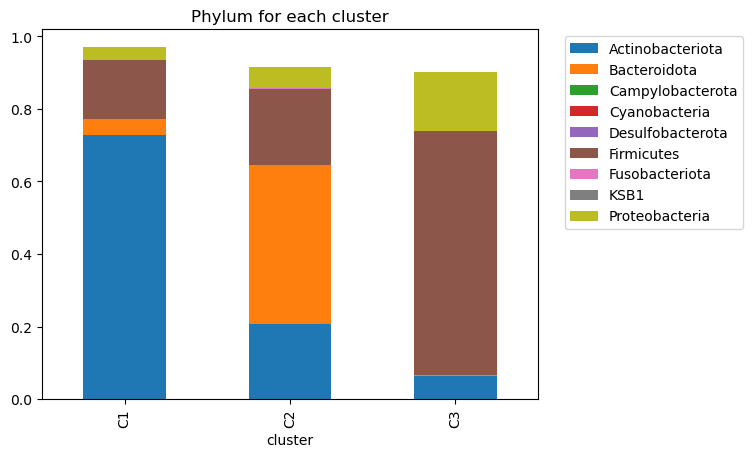

In [335]:
merged_taxa_map.reset_index()[['cluster']].groupby('cluster').sum()
merged_taxa_map_grouped = merged_taxa_map.groupby(lambda x: x, axis =0).mean()

# plot data in stack manner of bar type
merged_taxa_map_grouped.reset_index().plot(x='cluster', kind='bar', stacked=True,
        title='Phylum for each cluster')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

In [460]:
species_full = pd.read_csv('curated_abundances_through_p4.tsv', sep='\t')
species_full = species_full[species_full['taxRank'] =='species']
species_full = species_full[species_full['taxRank'] =='species']
species_full = species_full.drop(columns=['taxID','taxRank','genomeSize','numReads','numUniqueReads','seqid_full','seqID'])
species_full=species_full[species_full['abundance'] >= 0.001]
species_full_pivot = species_full.pivot(index='sample_id', values = 'abundance', columns = 'name')
species_full_pivot = species_full_pivot.fillna(0)

prev = pd.DataFrame(prevelance(species.set_index('sample_id')))
prevlist = list(prev[prev[0]<=5].reset_index()['index'])
species_full_pivot = species_full_pivot.drop(prevlist, axis=1)

/tmp/ipykernel_2599/561555997.py:1: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



In [461]:
taxa = pd.read_csv('bac_120_r207.tsv',sep='\t')
taxa[[0,"phylum",2,3,4,5,6]]= taxa.gtdb_taxonomy.apply(lambda x: pd.Series(str(x).split(";"))) #full_tax.gtdb_taxonomy.str.split(";", expand=True,)
taxa=taxa[['name','phylum']]
taxa[['tmp','p']]=taxa.phylum.apply(lambda x: pd.Series(str(x).split("__")))#   taxa['phylum'].str.split("__" ,expand=True,)
taxa =taxa[['name','p']]
taxa[['phylum',0]] = taxa.p.apply(lambda x: pd.Series(str(x).split("_")))#taxa['p'].str.split('_',expand=True,)
taxa = taxa[['name','phylum']]
taxa

taxa_dict = dict(zip(taxa.name, taxa.phylum))


# rename taxa based on phylum for all taxa except for bifido
species_full_pivot
merged_taxa_map =  pd.merge(species_full_pivot.reset_index(),meta_new[['sample_id',feat_keep]], left_on='sample_id',right_on='sample_id')
merged_taxa_map = merged_taxa_map.drop(columns='sample_id').set_index('cluster')
merged_taxa_map = merged_taxa_map.rename(columns=taxa_dict)
merged_taxa_map = merged_taxa_map.groupby(lambda x: x, axis =1).sum()

merged_taxa_map = merged_taxa_map.rename(columns={'Methanobrevibacter_A sp900766745':'Archaea'})

In [462]:
merged_taxa_map

Actinobacteriota  Bacteroidota  Campylobacterota  Cyanobacteria  \
cluster                                                                    
C1               0.154109      0.157759               0.0       0.000000   
C3               0.001918      0.000000               0.0       0.000000   
C1               0.914396      0.026982               0.0       0.000000   
C2               0.025205      0.443617               0.0       0.000000   
C1               0.685254      0.157471               0.0       0.001080   
...                   ...           ...               ...            ...   
C3               0.000000      0.003984               0.0       0.000000   
C1               0.688262      0.000000               0.0       0.000000   
C3               0.007129      0.000000               0.0       0.000000   
C3               0.000000      0.002563               0.0       0.001245   
C1               0.703840      0.000000               0.0       0.000000   

         Desulfobacterota  Firmicutes  Fusobacteriota      KSB1  Archaea  \
cluster                                                                    
C1                    0.0    0.601423        0.000000  0.000000      0.0   
C3                    0.0    0.778599        0.000000  0.001283      0.0   
C1                    0.0    0.015734        0.000000  0.000000      0.0   
C2                    0.0    0.442961        0.003127  0.000000      0.0   
C1                    0.0    0.108974        0.000000  0.000000      0.0   
...                   ...         ...             ...       ...      ...   
C3                    0.0    0.897736        0.000000  0.000000      0.0   
C1                    0.0    0.128795        0.000000  0.000000      0.0   
C3                    0.0    0.143490        0.000000  0.000000      0.0   
C3                    0.0    0.523768        0.000000  0.000000      0.0   
C1                    0.0    0.205447        0.000000  0.000000      0.0   

         Patescibacteria  Proteobacteria  Verrucomicrobiota  
cluster                                                      
C1                   0.0        0.009648                0.0  
C3                   0.0        0.186756                0.0  
C1                   0.0        0.010308                0.0  
C2                   0.0        0.016592                0.0  
C1                   0.0        0.014180                0.0  
...                  ...             ...                ...  
C3                   0.0        0.037414                0.0  
C1                   0.0        0.162628                0.0  
C3                   0.0        0.819572                0.0  
C3                   0.0        0.415763                0.0  
C1                   0.0        0.063475                0.0  

[289 rows x 12 columns]

In [465]:
merged_taxa_map_grouped.to_csv('phylum_level_sumamries_12122022.csv', sep=',')

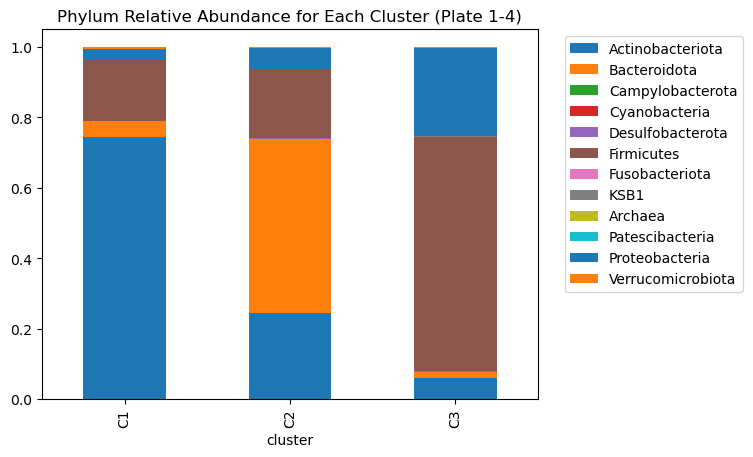

In [463]:
merged_taxa_map_grouped = merged_taxa_map.groupby(lambda x: x, axis =0).mean()
merged_taxa_map_grouped = merged_taxa_map_grouped.divide(merged_taxa_map_grouped.sum(axis=1), axis=0)
# plot data in stack manner of bar type
merged_taxa_map_grouped.reset_index().plot(x='cluster', kind='bar', stacked=True,
        title='Phylum Relative Abundance for Each Cluster (Plate 1-4)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

In [400]:
taxa.phylum.apply(lambda x: pd.Series(str(x).split(";")))

0
0       p__Proteobacteria
1         p__Bacteroidota
2       p__Proteobacteria
3       p__Proteobacteria
4       p__Proteobacteria
...                   ...
11838   p__Proteobacteria
11839  p__Planctomycetota
11840     p__Bacteroidota
11841   p__Proteobacteria
11842   p__Proteobacteria

[11843 rows x 1 columns]

In [389]:
full_tax[full_tax['name']=='Acinetobacter sp013009345'].gtdb_taxonomy.str.split(";", expand=True,)



0                  1                       2  \
38223  d__Bacteria  p__Proteobacteria  c__Gammaproteobacteria   

                        3                 4                 5  \
38223  o__Pseudomonadales  f__Moraxellaceae  g__Acinetobacter   

                                  6  
38223  s__Acinetobacter sp013009345

In [355]:
species_full = pd.read_csv('curated_abundances_through_p4.tsv', sep='\t')
species_full = species_full[species_full['taxRank'] =='species']

species_full_pivot
# prev = pd.DataFrame(prevelance(species.set_index('sample_id')))
# prevlist = list(prev[prev[0]<=8].reset_index()['index'])
# species = species.drop(prevlist, axis=1)
# species_clr = mr_clr(species.set_index('sample_id'))

# meta_new = pd.read_csv('limited_annotated_metadata_p4.tsv', sep='\t')

# feat_keep = 'cluster'
# merged_taxa_map =  pd.merge(species_full_pivot.reset_index(),meta_new[['sample_id',feat_keep]], left_on='sample_id',right_on='sample_id')
# merged_taxa_map = merged_taxa_map.drop(columns='sample_id').set_index('cluster')

# merged_taxa_map

0-14-0-10-38-17 sp002774085  0-14-0-20-30-16 sp002779075  \
cluster                                                             
C1                               0.0                          0.0   
C3                               0.0                          0.0   
C1                               0.0                          0.0   
C2                               0.0                          0.0   
C1                               0.0                          0.0   
...                              ...                          ...   
C3                               0.0                          0.0   
C1                               0.0                          0.0   
C3                               0.0                          0.0   
C3                               0.0                          0.0   
C1                               0.0                          0.0   

         0-14-0-20-30-16 sp903916665  0-14-0-20-34-12 sp002779065  \
cluster                                                             
C1                               0.0                          0.0   
C3                               0.0                          0.0   
C1                               0.0                          0.0   
C2                               0.0                          0.0   
C1                               0.0                          0.0   
...                              ...                          ...   
C3                               0.0                          0.0   
C1                               0.0                          0.0   
C3                               0.0                          0.0   
C3                               0.0                          0.0   
C1                               0.0                          0.0   

         0-14-0-20-40-13 sp002774285  0-14-0-20-44-26 sp002779055  \
cluster                                                             
C1                               0.0                          0.0   
C3                               0.0                          0.0   
C1                               0.0                          0.0   
C2                               0.0                          0.0   
C1                               0.0                          0.0   
...                              ...                          ...   
C3                               0.0                          0.0   
C1                               0.0                          0.0   
C3                               0.0                          0.0   
C3                               0.0                          0.0   
C1                               0.0                          0.0   

         0-14-0-20-45-22 sp002774355  0-14-0-20-51-18 sp002774685  \
cluster                                                             
C1                               0.0                          0.0   
C3                               0.0                          0.0   
C1                               0.0                          0.0   
C2                               0.0                          0.0   
C1                               0.0                          0.0   
...                              ...                          ...   
C3                               0.0                          0.0   
C1                               0.0                          0.0   
C3                               0.0                          0.0   
C3                               0.0                          0.0   
C1                               0.0                          0.0   

         0-14-0-80-42-15 sp002780005  0-14-0-80-44-23 sp002779235  ...  \
cluster                                                            ...   
C1                               0.0                          0.0  ...   
C3                               0.0                          0.0  ...   
C1                               0.0                          0.0  ...   
C2                               0.0           

In [ ]:
full_tax = pd.read_csv('bac_120_r207.tsv',sep='\t')
taxa[[0,"phylum",2,3,4,5,6]]=full_tax.gtdb_taxonomy.str.split(";", expand=True,)
taxa=taxa[['name','phylum']]
taxa[['tmp','p']]=taxa['phylum'].str.split("__" ,expand=True,)
taxa =taxa[['name','p']]
taxa[['phylum',0]] = taxa['p'].str.split('_',expand=True,)
taxa = taxa[['name','phylum']]
taxa

taxa_dict = dict(zip(taxa.name, taxa.phylum))


# rename taxa based on phylum for all taxa except for bifido
merged_taxa_map = merged_taxa_map.rename(columns=taxa_dict)
merged_taxa_map = merged_taxa_map.groupby(lambda x: x, axis =1).sum()
merged_taxa_map.head(2)

name           phylum
0      Anaerosporobacter sp018372435   Proteobacteria
1       Bifidobacterium adolescentis     Bacteroidota
2            Bifidobacterium bifidum   Proteobacteria
3              Bifidobacterium breve   Proteobacteria
4           Bifidobacterium infantis   Proteobacteria
...                              ...              ...
11838            UBA9414 sp018365895   Proteobacteria
11839           UMGS1071 sp900542375  Planctomycetota
11840           UMGS1540 sp900552775     Bacteroidota
11841           UMGS1572 sp900553045   Proteobacteria
11842        Veillonella sp900757715   Proteobacteria

[11843 rows x 2 columns]

In [344]:
species_full.head()

name  taxID  taxRank  genomeSize  numReads  numUniqueReads  \
0              root      1  no rank           0       287             287   
1   Acidobacteriota      9   phylum           0         2               0   
2  Actinobacteriota     10   phylum           0        12               0   
3      Firmicutes_A     74   phylum           0         1               0   
4      Firmicutes_B     75   phylum           0         1               0   

   abundance                                         seqid_full  \
0        0.0  22130FL-03-01-80_S103_L002_R1_001_val_1-report...   
1        0.0  22130FL-03-01-80_S103_L002_R1_001_val_1-report...   
2        0.0  22130FL-03-01-80_S103_L002_R1_001_val_1-report...   
3        0.0  22130FL-03-01-80_S103_L002_R1_001_val_1-report...   
4        0.0  22130FL-03-01-80_S103_L002_R1_001_val_1-report...   

              seqID  sample_id  
0  22130FL-03-01-80  PBT-03217  
1  22130FL-03-01-80  PBT-03217  
2  22130FL-03-01-80  PBT-03217  
3  22130FL-03-01-80  PBT-03217  
4  22130FL-03-01-80  PBT-03217

In [309]:
metabolomics_metadata_data = metabolomics_metadata.copy()

metabolomics_metadata_data[['bmonth','bday','byear']]=metabolomics_metadata_data["Baby's Birthday"].str.split("/" ,expand=True,)
metabolomics_metadata_data[['cmonth','cday','cyear']]=metabolomics_metadata_data["Collection Date"].str.split("/" ,expand=True,)
# metabolomics_metadata_data[['days_since_collection']] = (int(metabolomics_metadata_data['cmonth'])+int(metabolomics_metadata_data['bday'])) - (int(metabolomics_metadata_data['bmonth'])+int(metabolomics_metadata_data['bday']))
# metabolomics_metadata_data
metabolomics_metadata_data[['birth']] = metabolomics_metadata_data[['bmonth','bday']].apply(lambda x: int(x) +int(x) in metabolomics_metadata_data['bmonth and metabolomics_metadata_data'] )
metabolomics_metadata_data[['birth']] = metabolomics_metadata_data[['bmonth','bday']].apply(lambda x: int(x) +int(x) in metabolomics_metadata_data['bmonth'] and  )



sample_name                                        Baby’s Race  \
0    PBT-03005                                       White, Asian   
1    PBT-03008                                              White   
2    PBT-03015                                              White   
3    PBT-03016                                              White   
4    PBT-03017                                              White   
5    PBT-03020                                              White   
6    PBT-03021                                              White   
7    PBT-03024                                              White   
8    PBT-03026                                              White   
9    PBT-03029                                              White   
10   PBT-03033                                       White, Asian   
11    PBT-3040                                              White   
12   PBT-03051            White, American Indian or Alaska Native   
13   PBT-03055  White, Asian, Native Hawaiian or Other Pacific...   
14   PBT-03056                                              White   
15   PBT-03060                                              White   
16   PBT-03061                                              White   
17   PBT-03064                                              White   
18   PBT-03065                                              White   
19   PBT-03067                                              White   
20   PBT-03070                                              White   
21   PBT-03073                                              White   
22   PBT-03074                                              White   
23   PBT-03075                                              White   
24   PBT-03076                                              White   
25   PBT-03078                   White, Black or African American   
26   PBT-03084                                              White   
27   PBT-03085                                              White   
28   PBT-03088                                              White   
29   PBT-03089                                              White   
30   PBT-03092                          Black or African American   
31   PBT-03098                                              White   
32   PBT-03100                                              White   
33   PBT-03103                                              White   
34   PBT-03104                                              White   
35   PBT-03111                                              White   
36   PBT-03112                                              White   
37   PBT-03116                                              White   
38   PBT-03130                                              White   
39   PBT-03143                                              Asian   
40   PBT-03145                                              White   
41   PBT-03147                                              White   
42   PBT-03150                                              White   
43   PBT-03151                                              White   
44   PBT-03153                                              White   
45   PBT-03159                                              White   
46   PBT-03174                                              White   
47   PBT-03181                                              White   
48   PBT-03204                   White, Black or African American   
49   PBT-03217                                              White   

          Baby’s Ethnicity Baby Feeding How was Baby Birthed? Baby's Birthday  \
0   Not Hispanic or Latino   Breast Fed             Vaginally       6/23/2022   
1   Not Hispanic or Latino   Breast Fed             Vaginally       5/29/2022   
2   Not Hispanic or Latino   Breast Fed             Vaginally       6/14/2022   
3   Not Hispanic or Latino   Breast Fed             Vaginally       6/15/2022   
4   Not Hispanic or Latino        Mixed             Vaginally       6/15/2022 

In [502]:
from datetime import datetime
def delta_days(birth, collection):
    
    date_format = "%m/%d/%Y"
    a = datetime.strptime(birth, date_format)
    b = datetime.strptime(collection, date_format)
    delta = b - a
    return (delta.days) # that's it

def update_metadata_delta_days(metadata, birthcol, collectcol):
    metadataup=metadata.copy()
    for i in range(1,metadataup.shape[0]):
        delta = delta_days(metadataup[birthcol].iloc[i],
                          metadataup[collectcol.iloc[i]])
        metadataup['delta_days'].iloc[i] = delta
        return metadataup

In [488]:
from datetime import datetime
date_format = "%m/%d/%Y"
a = datetime.strptime('6/23/2022', date_format)
b = datetime.strptime('8/3/2022', date_format)
delta = b - a
print (delta.days) # that's it

41


In [504]:
for i in range(1,metabolomics_metadata_data.shape[0]):
    delta = delta_days(metabolomics_metadata_data["Baby's Birthday"].iloc[i], 
                       metabolomics_metadata_data["Collection Date"].iloc[i])
    print(delta)

72
57
77
56
59
87
43
65
72
56
47
41
38
38
44
44
34
33
33
53
53
83
54
41
72
36
46
62
57
40
36
37
64
38
42
61
46
46
23
39
66
32
46
38
61
31
36
55
46


In [491]:
metabolomics_metadata_data[["Baby's Birthday",'Collection Date']].apply(delta_days(["Baby's Birthday"],['Collection Date']))

TypeError: strptime() argument 1 must be str, not list

In [500]:
metabolomics_metadata_data[["Baby's Birthday",'Collection Date']].apply(lambda x: for len(x))

50
50


Baby's Birthday    None
Collection Date    None
dtype: object

In [466]:
from datetime import date

d0 = date(2008, 8, 18)
d1 = date(2008, 9, 26)
delta = d1 - d0
print(delta.days)

39


In [307]:
def year_month(ts):
    monn = str(ts.month)
    yrr = str(ts.year)
    if len(monn) == 1:
        monn = f'{str(0)}{monn}'
    return f'{yrr}-{monn}'

proc_date['year_month'] = proc_date['updated'].apply(year_month)
month_uniq = sorted(proc_date['year_month'].unique())
month_uniq_value = [j+1 for j in range(len(month_uniq))]
proc_date['year_month_value'] = proc_date['year_month'].replace(month_uniq, month_uniq_value)
proc_date.set_index('sampleid', inplace=True)

TypeError: cannot convert the series to <class 'float'>